### Importing the relevant libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely.vectorized as sv
from shapely.geometry import Point, Polygon
from time import time
from math import radians, cos, sin, asin, sqrt
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [2]:
vic_locality_polygon = gpd.read_file('vic_locality_polygon_shp-gda2020/VIC_LOCALITY_POLYGON_shp GDA2020/VIC_LOCALITY_POLYGON_shp.shp')

In [3]:
bushfire_all_aus = gpd.read_file('NIAFED_20190701_20200323_v20200324/NIAFED_20190701_20200323_v20200324.shp')

In [4]:
species_vic_also = gpd.read_file('species_vic_also.shp')

### Preprocessing species data

In [5]:
len(species_vic_also)

562

In [6]:
species_vic_also.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    562 non-null    int64   
 1   Shape_Leng  562 non-null    float64 
 2   Shape_Area  562 non-null    float64 
 3   listed_id   562 non-null    object  
 4   map_id      562 non-null    object  
 5   sci_name    562 non-null    object  
 6   comm_name   555 non-null    object  
 7   threatened  509 non-null    object  
 8   migratory   136 non-null    object  
 9   pres_rank   562 non-null    object  
 10  category    562 non-null    object  
 11  extracted   562 non-null    object  
 12  tax_group   562 non-null    object  
 13  tax_family  562 non-null    object  
 14  tax_order   562 non-null    object  
 15  tax_class   562 non-null    object  
 16  tax_phylum  562 non-null    object  
 17  tax_king    562 non-null    object  
 18  other_ids   215 non-null    object  
 19  

**Columns having some null values:** 
1. comm_name
2. threatened
3. migratory
4. other_ids

In [7]:
list_null_col = ['comm_name', 'threatened', 'migratory', 'other_ids']

In [8]:
species_vic_also_mod = species_vic_also.dropna(axis=0, subset=['comm_name', 'threatened']).copy()

In [9]:
species_vic_also_mod.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'listed_id', 'map_id',
       'sci_name', 'comm_name', 'threatened', 'migratory', 'pres_rank',
       'category', 'extracted', 'tax_group', 'tax_family', 'tax_order',
       'tax_class', 'tax_phylum', 'tax_king', 'other_ids', 'cell_size',
       'regions', 'attributio', 'sprat_prof', 'geometry'],
      dtype='object')

In [10]:
species_vic_also_mod.tax_group.unique()

array(['mammals', 'flora', 'birds', 'other-animals', 'fishes', 'reptiles',
       'frogs'], dtype=object)

In [11]:
species_vic_also_mod_con = species_vic_also_mod.loc[species_vic_also_mod['tax_group'] != 'flora']

In [12]:
species_vic_also_mod_con.head()

,OBJECTID,Shape_Leng,Shape_Area,listed_id,map_id,sci_name,comm_name,threatened,migratory,pres_rank,...,tax_order,tax_class,tax_phylum,tax_king,other_ids,cell_size,regions,attributio,sprat_prof,geometry
0,35,803.88,1340.4448,36,36,Balaenoptera musculus,Blue Whale,Endangered,Migratory,2,...,Cetacea,Mammalia,Chordata,Animalia,None,0.01,NT; CI; QLD; NSW; TAS; VIC; WA; ACI; CSI; SA; ...,Species 1km Grids August 2019 Canberra: Depart...,http://www.environment.gov.au/cgi-bin/sprat/pu...,"MULTIPOLYGON (((153.22000 -68.35000, 153.25000..."
1,36,396.02,373.2306,36,36,Balaenoptera musculus,Blue Whale,Endangered,Migratory,1,...,Cetacea,Mammalia,Chordata,Animalia,None,0.01,NT; CI; QLD; NSW; TAS; VIC; WA; ACI; CSI; SA; ...,Species 1km Grids August 2019 Canberra: Depart...,http://www.environment.gov.au/cgi-bin/sprat/pu...,"MULTIPOLYGON (((133.51000 -32.14000, 133.50000..."
2,43,400.30,265.6278,40,40,Eubalaena australis,Southern Right Whale,Endangered,None,2,...,Cetacea,Mammalia,Chordata,Animalia,75529,0.01,QLD; NSW; TAS; VIC; WA; CSI; SA; HMI; AAT; JBT...,Species 1km Grids August 2019 Canberra: Depart...,http://www.environment.gov.au/cgi-bin/sprat/pu...,"MULTIPOLYGON (((159.04000 -51.00000, 159.04000..."
3,44,696.52,964.8850,40,40,Eubalaena australis,Southern Right Whale,Endangered,None,1,...,Cetacea,Mammalia,Chordata,Animalia,75529,0.01,QLD; NSW; TAS; VIC; WA; CSI; SA; HMI; AAT; JBT...,Species 1km Grids August 2019 Canberra: Depart...,http://www.environment.gov.au/cgi-bin/sprat/pu...,"MULTIPOLYGON (((142.05000 -63.44000, 142.05000..."
4,84,8.06,0.6568,77,77,Pseudomys shortridgei,"Heath Mouse, Dayang, Heath Rat",Endangered,None,2,...,Rodentia,Mammalia,Chordata,Animalia,None,0.01,VIC; WA; SA,Species 1km Grids August 2019 Canberra: Depart...,http://www.environment.gov.au/cgi-bin/sprat/pu...,"MULTIPOLYGON (((141.16000 -37.39000, 141.16000..."


In [13]:
len(species_vic_also_mod_con)

263

In [14]:
species_vic_also_mod_con.reset_index(inplace = True)

In [15]:
species_vic_also_mod_con.to_file('species_vic_also_mod_con.shp')

**Random location coordinate below:** Format - long,lat => converted to point format so as to be used by shapely library

In [16]:
c_1 = Point(145.0571, -37.8892)

In [17]:
c_1.x, c_1.y

(145.0571, -37.8892)

### Person within bushfire affected area?

In [18]:
print('Using Shapely...........')
start = time()
if sv.contains(bushfire_all_aus.geometry[0],c_1.x, c_1.y).flat[0]:
    print('Your location coordinates lie within the 2019-2020 bushfire affected region')
else:
    print('Your location coordinates lie outside the 2019-2020 bushfire affected region')
end = time()
print('Time taken for this operation:',round(((end-start)/60),2),'minutes')

Using Shapely...........
Your location coordinates lie outside the 2019-2020 bushfire affected region
Time taken for this operation: 0.02 minutes


### Suburb of the user - No API calls or use of service or geocoding - Already have the shape file data defining suburb boundaries.

In [19]:
j = 0
for i in range(len(vic_locality_polygon)):
    if c_1.within(vic_locality_polygon.geometry[i]):
        print('Your suburb is',vic_locality_polygon.iloc[j,6])
        suburb = vic_locality_polygon.iloc[j,6]
    j+=1

Your suburb is CARNEGIE


### How far from the nearest bushfire affected region the user is

This distance doesn't refer to the driving distance to that area, but is rather approximated as a straight line distance between your location and the nearest point defining the bushfire boundary. The actual distance is going to be greater than this mentioned distance

In [20]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

**Credits for the above code for calculation of distance between a pair of latitudes and longitudes:** https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [21]:
start = time()
list_dist_all = []
for i in bushfire_all_aus.geometry[0]:
    j=0
    x, y = i.exterior.coords.xy
    for i in range(len(x)):
        list_dist_all.append(haversine(c_1.x, c_1.y, x[j], y[j]))
        j+=1
print('Minimum distance from the bushfire affected region:', round(min(list_dist_all),2),'km')
end = time()
print('Time taken for this operation:',round(((end-start)/60),2),'minutes')

Minimum distance from the bushfire affected region: 12.79 km
Time taken for this operation: 1.0 minutes


### Checking for vulnerable species around user's location

In [22]:
def species_finder(coords_inp):
    x,y = coords_inp.split(' ')
    x = float(x)
    y = float(y)
    c_1 = Point(x,y)
    j = 0
    list_found =[]
    for i in range(len(species_vic_also_mod_con)):
        try:
            if c_1.within(species_vic_also_mod_con.geometry[i]):
                list_found.append(j)
            j+=1
        except:
            if c_1.within(species_vic_also_mod_con.geometry[i].buffer(0)):
                list_found.append(j)
            j+=1
    
    '''
    Subsetting our dataframe based on the species habitat in the user's location and selecting the columns of interest to be shown to the client side.
    '''

    species_found = species_vic_also_mod_con[species_vic_also_mod_con.index.isin(list_found)].copy()
    df_found = species_found[['comm_name', 'tax_group','pres_rank', 'threatened']].copy()


    '''
        
        As per the data,
        pres_rank = 1 => corresponds to 'Species or species habitat may occur within area'
        pres_rank = 2 => corresponds to 'Species or species habitat is likely to occur within area'
        
    '''

    df_found.loc[df_found['pres_rank'] =='1' , 'pres_rank'] = 'May Occur in this region'
    df_found.loc[df_found['pres_rank'] =='2' , 'pres_rank'] = 'Likely to Occur in this region'

    '''
    Output to json format
    '''
    df_found.columns = ['Common Name', 'Species Class', 'Likelihood of Occurence', 'Conservation Status']
    # out = df_found.to_json(orient='records')[1:-1]
    out = df_found.to_json(orient='records')
    return df_found

In [23]:
species_finder(str(c_1.x) + ' ' + str(c_1.y))

,Common Name,Species Class,Likelihood of Occurence,Conservation Status
23,"Red Knot, Knot",birds,May Occur in this region,Endangered
27,Australasian Bittern,birds,Likely to Occur in this region,Endangered
46,"Spot-tailed Quoll, Spotted-tail Quoll, Tiger Q...",mammals,May Occur in this region,Endangered
74,"Southern Brown Bandicoot (eastern), Southern B...",mammals,May Occur in this region,Endangered
75,"Australian Painted-snipe, Australian Painted S...",birds,Likely to Occur in this region,Endangered
95,Swift Parrot,birds,Likely to Occur in this region,Critically Endangered
101,"Eastern Curlew, Far Eastern Curlew",birds,May Occur in this region,Critically Endangered
107,Curlew Sandpiper,birds,May Occur in this region,Critically Endangered
109,Plains-wanderer,birds,Likely to Occur in this region,Critically Endangered
116,Regent Honeyeater,birds,Likely to Occur in this region,Critically Endangered


### Finding neighbouring suburbs

In [24]:
vic_locality_polygon.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74553 -35.07227, 141.74553 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39570, 148.66877 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92289 -37.97885, 142.90450 -37.9..."
3,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66000, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27979 -35.99858, 141.27989 -35.9..."


In [25]:
vic_neigh = vic_locality_polygon.copy()

In [26]:
j=0
len_neigh = len(vic_neigh)
for index, row in vic_neigh.iterrows():  
    neighbors = vic_neigh[vic_neigh.geometry.touches(row['geometry'])].VIC_LOCA_2.tolist() 
#     neighbors = neighbors.remove(row.VIC_LOCA_2)
    vic_neigh.at[index, "my_neighbors"] = ", ".join(neighbors)
    print('Progress {} out of {}'.format(j+1,len_neigh), end='\r')
    j+=1

In [27]:
vic_neigh

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry,my_neighbors
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74553 -35.07227, 141.74553 -35.0...","LINGA, TORRITA, BIG DESERT"
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39570, 148.66877 -37.3...","YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92289 -37.97885, 142.90450 -37.9...","HEXHAM, MORTLAKE, LAKE BOLAC, NERRIN NERRIN, D..."
3,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66000, 147.82313 -37.6...","MARTHAVALE, STIRLING, TAMBO CROSSING, WATERHOL..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27979 -35.99858, 141.27989 -35.9...","NHILL, TELOPEA DOWNS, NETHERBY, BIG DESERT, BR..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,10496,2016-12-16,None,VIC2578,2017-02-02,None,TRAYNORS LAGOON,None,None,G,None,2,"POLYGON ((143.02095 -36.60376, 143.01862 -36.6...","YORK PLAINS, AVON PLAINS, MARNOO EAST, GRE GRE..."
2969,8299,2011-08-31,None,VIC2075,2012-04-27,None,PIRA,None,None,G,None,2,"POLYGON ((143.36720 -35.21417, 143.36975 -35.2...","NYAH WEST, WOORINEN NORTH, WOORINEN SOUTH, NYR..."
2970,9272,2011-08-31,None,VIC2696,2012-04-27,None,WARMUR,None,None,G,None,2,"POLYGON ((142.81039 -36.05533, 142.80808 -36.0...","BALLAPUR, BIRCHIP WEST, MORTON PLAINS, WATCHEM..."
2971,9728,2013-02-22,None,VIC2375,2013-04-30,None,STRATHALLAN,None,None,G,None,2,"POLYGON ((144.80653 -36.22543, 144.81374 -36.2...","BALLENDELLA, NANNEELLA, FAIRY DELL, KOYUGA, EC..."


### Area burnt for each suburb

In [28]:
vic_neigh_copy = vic_neigh.copy()

In [29]:
vic_neigh_copy = vic_neigh_copy.to_crs({'init': 'epsg:3122'})

c:\python38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [30]:
vic_neigh_copy['area'] = vic_neigh_copy.area/ 10**6

In [31]:
vic_neigh_copy.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry,my_neighbors,area
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((2592408.014 -4128537.387, 2592415.50...","LINGA, TORRITA, BIG DESERT",393.462968
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((3154435.966 -4579919.927, 3154435.47...","YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ...",417.553486
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((2615472.956 -4485762.992, 2613891.38...","HEXHAM, MORTLAKE, LAKE BOLAC, NERRIN NERRIN, D...",364.378835
3,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,"POLYGON ((3067419.489 -4583846.524, 3067399.41...","MARTHAVALE, STIRLING, TAMBO CROSSING, WATERHOL...",409.366122
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((2523842.426 -4223283.549, 2523852.77...","NHILL, TELOPEA DOWNS, NETHERBY, BIG DESERT, BR...",380.554935


Above **area** calculated is in **meter square**

### Percentage of area burnt relative to total area

In [32]:
vic_neigh_copy_4283 = vic_neigh_copy.to_crs({'init': 'epsg:4283'})

c:\python38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [33]:
vic_locality_polygon.crs

<Geographic 2D CRS: GEOGCS["GDA2020",DATUM["D_Geocentric_Datum_of_Aust ...>
Name: GDA2020
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [34]:
vic_locality_polygon_4283 = vic_locality_polygon.to_crs({'init':'epsg:4283'})

c:\python38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [35]:
vic_locality_polygon_4283.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."


In [36]:
bushfire_all_aus.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Now we would have to find the intersection of the Victorian state and bushfire regions all over Australia to only get the bushfire locations within Victoria

In [37]:
vic_locality_polygon_4283

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,10496,2016-12-16,None,VIC2578,2017-02-02,None,TRAYNORS LAGOON,None,None,G,None,2,"POLYGON ((143.02095 -36.60378, 143.01861 -36.6..."
2969,8299,2011-08-31,None,VIC2075,2012-04-27,None,PIRA,None,None,G,None,2,"POLYGON ((143.36719 -35.21418, 143.36975 -35.2..."
2970,9272,2011-08-31,None,VIC2696,2012-04-27,None,WARMUR,None,None,G,None,2,"POLYGON ((142.81038 -36.05535, 142.80808 -36.0..."
2971,9728,2013-02-22,None,VIC2375,2013-04-30,None,STRATHALLAN,None,None,G,None,2,"POLYGON ((144.80652 -36.22544, 144.81373 -36.2..."


In [38]:
# from time import time
# start = time()
# inter_bush = gpd.overlay(vic_locality_polygon_4283, bushfire_all_aus, how='intersection')
# end = time()
# print('Time taken for this operation', round((end-start)/60,2), 'minutes')

In [39]:
#if the above command doesn't work, run this cell

inter_bush = gpd.read_file('inter_bush.shp')

**Burnt area** within **Victoria** visualized below:

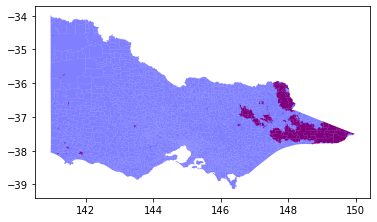

In [40]:
ax = inter_bush.plot(color='red')
# fire_history_2019.plot(ax = ax, color='red', alpha = 2)
vic_locality_polygon_4283.plot(ax=ax, color='blue', alpha = 0.5)
plt.show()

In [41]:
# inter_bush.to_file('inter_bush.shp')

In [42]:
inter_bush_neigh = inter_bush.copy()

#### Finding neighbours of the burnt suburbs

In [43]:
j=0
len_bush_neigh = len(inter_bush_neigh)
for index, row in inter_bush_neigh.iterrows():  
    neighbors = inter_bush_neigh[inter_bush_neigh.geometry.touches(row['geometry'])].VIC_LOCA_2.tolist() 
#     neighbors = neighbors.remove(row.VIC_LOCA_2)
    inter_bush_neigh.at[index, "my_neighbors"] = ", ".join(neighbors)
    print('Progress {} out of {}'.format(j+1,len_bush_neigh), end='\r')
    j+=1

**Burnt Area** for just the **affected suburb**

In [44]:
inter_bush_neigh_3112 = inter_bush_neigh.to_crs({'init': 'epsg:3122'})

inter_bush_neigh_3112['area'] = inter_bush_neigh_3112.area/ 10**6

c:\python38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [45]:
inter_bush_neigh_3112.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,Id,geometry,my_neighbors,area
0,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,0,"POLYGON Z ((3154435.966 -4579919.927 0.000, 31...","YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ...",417.553486
1,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,0,"POLYGON Z ((2620061.043 -4466609.240 0.000, 26...","NERRIN NERRIN, DUNDONNELL",0.184856
2,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,0,"POLYGON Z ((3065619.759 -4582948.801 0.000, 30...","MARTHAVALE, STIRLING, TAMBO CROSSING, WATERHOL...",407.126795
3,6393,2011-08-31,None,VIC1743,2012-04-27,None,MOORALLA,None,None,G,None,2,0,"POLYGON Z ((2556443.139 -4399167.444 0.000, 25...",,0.087065
4,6405,2011-08-31,None,VIC1688,2012-04-27,None,MINIMAY,None,None,G,None,2,0,"POLYGON Z ((2503745.105 -4301508.213 0.000, 25...",,0.014998


In [46]:
len(inter_bush_neigh_3112.my_neighbors.unique())

190

#### Finally the below calculation will give the percentage of area burnt relative to total area:

In [47]:
m = vic_neigh_copy.LC_PLY_PID.isin(inter_bush_neigh_3112.LC_PLY_PID)

In [48]:
vic_neigh_copy_m = vic_neigh_copy[m].copy()

In [49]:
vic_neigh_copy_m.reset_index(inplace = True)

In [50]:
inter_bush_neigh_3112['percent_area_affected'] = round((inter_bush_neigh_3112['area']/vic_neigh_copy_m['area'])*100,3)

In [51]:
inter_bush_neigh_3112

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,Id,geometry,my_neighbors,area,percent_area_affected
0,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,0,"POLYGON Z ((3154435.966 -4579919.927 0.000, 31...","YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ...",417.553486,100.000
1,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,0,"POLYGON Z ((2620061.043 -4466609.240 0.000, 26...","NERRIN NERRIN, DUNDONNELL",0.184856,0.051
2,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,0,"POLYGON Z ((3065619.759 -4582948.801 0.000, 30...","MARTHAVALE, STIRLING, TAMBO CROSSING, WATERHOL...",407.126795,99.453
3,6393,2011-08-31,None,VIC1743,2012-04-27,None,MOORALLA,None,None,G,None,2,0,"POLYGON Z ((2556443.139 -4399167.444 0.000, 25...",,0.087065,0.033
4,6405,2011-08-31,None,VIC1688,2012-04-27,None,MINIMAY,None,None,G,None,2,0,"POLYGON Z ((2503745.105 -4301508.213 0.000, 25...",,0.014998,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,10271,2016-02-26,None,VIC1971,2016-05-05,None,NOWA NOWA,None,None,G,None,2,0,MULTIPOLYGON Z (((3093387.081 -4599386.825 0.0...,"BUCHAN SOUTH, DOUBLE BRIDGES",118.320584,42.385
317,8178,2011-08-31,None,VIC868,2012-04-27,None,ENSAY NORTH,None,None,G,None,2,0,"POLYGON Z ((3087696.846 -4549311.423 0.000, 30...","ENSAY, NUNNIONG",7.464062,9.353
318,9851,2013-11-26,None,VIC1376,2012-04-27,None,KOOLOONONG,None,None,G,None,2,0,"POLYGON Z ((2727003.195 -4129835.474 0.000, 27...",,0.418951,0.098
319,8388,2011-08-31,None,VIC538,2012-04-27,None,CHEPSTOWE,None,None,G,None,2,0,MULTIPOLYGON Z (((2680789.043 -4453428.349 0.0...,,0.003378,0.005


In [52]:
vic_csv = vic_neigh_copy[~vic_neigh_copy.LC_PLY_PID.isin(inter_bush_neigh_3112.LC_PLY_PID)].copy()

In [53]:
vic_csv['percent_area_affected'] = 0

In [54]:
inter_bush_neigh_3112_copy =  inter_bush_neigh_3112.copy()
vic_csv_copy = vic_csv.copy()

In [55]:
inter_bush_neigh_3112_copy['bushfire_affected'] = 'Yes'
vic_csv_copy['bushfire_affected'] = 'No'

In [56]:
vic_csv_1 = pd.concat([inter_bush_neigh_3112_copy, vic_csv_copy])

In [57]:
vic_csv_1.dtypes

LC_PLY_PID                 object
DT_CREATE                  object
DT_RETIRE                  object
LOC_PID                    object
VIC_LOCALI                 object
VIC_LOCA_1                 object
VIC_LOCA_2                 object
VIC_LOCA_3                 object
VIC_LOCA_4                 object
VIC_LOCA_5                 object
VIC_LOCA_6                 object
VIC_LOCA_7                 object
Id                        float64
geometry                 geometry
my_neighbors               object
area                      float64
percent_area_affected     float64
bushfire_affected          object
dtype: object

In [58]:
vic_csv_1[["LC_PLY_PID"]] = vic_csv_1[["LC_PLY_PID"]].apply(pd.to_numeric)

In [59]:
vic_csv_2 = vic_csv_1[["LC_PLY_PID", "VIC_LOCA_2", "my_neighbors", "area", "percent_area_affected", "bushfire_affected"]].copy()

In [60]:
vic_csv_2.columns = ['id', 'Suburb', 'neighboring_suburbs', 'area', 'percent_area_affected', 'bushfire_affected']

In [61]:
vic_csv_2

,id,Suburb,neighboring_suburbs,area,percent_area_affected,bushfire_affected
0,6671,NURRAN,"YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ...",417.553486,100.000,Yes
1,6672,WOORNDOO,"NERRIN NERRIN, DUNDONNELL",0.184856,0.051,Yes
2,6673,DEPTFORD,"MARTHAVALE, STIRLING, TAMBO CROSSING, WATERHOL...",407.126795,99.453,Yes
3,6393,MOORALLA,,0.087065,0.033,Yes
4,6405,MINIMAY,,0.014998,0.005,Yes
...,...,...,...,...,...,...
2967,8308,NORMANVILLE,"PINE VIEW, DINGWALL, WANDELLA, SANDHILL LAKE, ...",73.985330,0.000,No
2968,10496,TRAYNORS LAGOON,"YORK PLAINS, AVON PLAINS, MARNOO EAST, GRE GRE...",78.577501,0.000,No
2969,8299,PIRA,"NYAH WEST, WOORINEN NORTH, WOORINEN SOUTH, NYR...",66.018331,0.000,No
2970,9272,WARMUR,"BALLAPUR, BIRCHIP WEST, MORTON PLAINS, WATCHEM...",117.593796,0.000,No


**Area** is approximate and is in **km-square**

In [62]:
vic_csv_2.to_csv('suburb_affected_area.csv', index = False)

### Preprocessing the bushfire data with state of Victoria to get improved efficiency for distance calculation

In [63]:
inter_bush_neigh.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,Id,geometry,my_neighbors
0,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,0,"POLYGON Z ((148.66877 -37.39570 0.00000, 148.6...","YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ..."
1,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,0,"POLYGON Z ((142.91631 -37.81083 0.00000, 142.9...","NERRIN NERRIN, DUNDONNELL"
2,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,0,"POLYGON Z ((147.80250 -37.65769 0.00000, 147.7...","MARTHAVALE, STIRLING, TAMBO CROSSING, WATERHOL..."
3,6393,2011-08-31,None,VIC1743,2012-04-27,None,MOORALLA,None,None,G,None,2,0,"POLYGON Z ((142.06991 -37.39312 0.00000, 142.0...",
4,6405,2011-08-31,None,VIC1688,2012-04-27,None,MINIMAY,None,None,G,None,2,0,"POLYGON Z ((141.26845 -36.69152 0.00000, 141.2...",


In [64]:
# from shapely.geometry.polygon import Polygon
# from shapely.geometry.multipolygon import MultiPolygon

In [65]:
# gdf["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
#     else feature for feature in gdf["geometry"]]

In [66]:
s = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in inter_bush_neigh["geometry"]]

In [67]:
s

In [68]:
inter_bush_neigh_dissolve = inter_bush_neigh.copy()

In [69]:
inter_bush_neigh_dissolve['region'] = 'VICTORIA'

In [70]:
inter_bush_neigh_dissolve.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,Id,geometry,my_neighbors,region
0,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,0,"POLYGON Z ((148.66877 -37.39570 0.00000, 148.6...","YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ...",VICTORIA
1,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,0,"POLYGON Z ((142.91631 -37.81083 0.00000, 142.9...","NERRIN NERRIN, DUNDONNELL",VICTORIA
2,6673,2011-08-31,None,VIC734,2018-08-03,None,DEPTFORD,None,None,G,None,2,0,"POLYGON Z ((147.80250 -37.65769 0.00000, 147.7...","MARTHAVALE, STIRLING, TAMBO CROSSING, WATERHOL...",VICTORIA
3,6393,2011-08-31,None,VIC1743,2012-04-27,None,MOORALLA,None,None,G,None,2,0,"POLYGON Z ((142.06991 -37.39312 0.00000, 142.0...",,VICTORIA
4,6405,2011-08-31,None,VIC1688,2012-04-27,None,MINIMAY,None,None,G,None,2,0,"POLYGON Z ((141.26845 -36.69152 0.00000, 141.2...",,VICTORIA


In [71]:
inter_bush_neigh_dissolve_1 = inter_bush_neigh_dissolve.dissolve(by='region')

In [72]:
inter_bush_neigh_dissolve_1

,geometry,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,Id,my_neighbors
region,,,,,,,,,,,,,,,
VICTORIA,"MULTIPOLYGON Z (((148.70358 -37.78765 0.00000,...",6671,2011-08-31,NaN,VIC1986,2012-04-27,NaN,NURRAN,NaN,3312,G,NaN,2,0,"YALMY, CABBAGE TREE CREEK, GOONGERAH, ORBOST, ..."


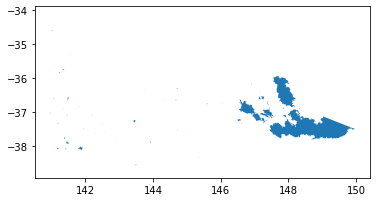

In [73]:
inter_bush_neigh_dissolve_1.plot()

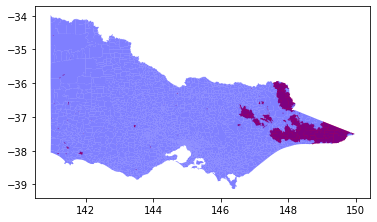

In [74]:
ax = inter_bush_neigh_dissolve_1.plot(color='red')
# fire_history_2019.plot(ax = ax, color='red', alpha = 2)
vic_locality_polygon_4283.plot(ax=ax, color='blue', alpha = 0.5)
plt.show()

In [75]:
inter_bush_neigh_dissolve_geom = inter_bush_neigh_dissolve_1[['geometry']].copy()

In [76]:
inter_bush_neigh_dissolve_geom

,geometry
region,
VICTORIA,"MULTIPOLYGON Z (((148.70358 -37.78765 0.00000,..."


In [77]:
inter_bush_neigh_dissolve_geom.to_file('inter_bush_neigh_dissolve_geom.shp')

The **burnt area** in **Victoria** has now been **isolated** into a **single multipolygon**

I will now try my **distance logic** on **this shapefile**

In [78]:
inter_bush_neigh_dissolve_geom = gpd.read_file('inter_bush_neigh_dissolve_geom.shp')

In [79]:
inter_bush_neigh_dissolve_geom

,region,geometry
0,VICTORIA,"MULTIPOLYGON Z (((148.70358 -37.78765 0.00000,..."


#### Starting the distance calculation....

In [80]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

**Credits for the above code for calculation of distance between a pair of latitudes and longitudes:** https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [81]:
start = time()
list_dist_all = []
for i in inter_bush_neigh_dissolve_geom.geometry[0]:
    j=0
    x, y = i.exterior.coords.xy
    for i in range(len(x)):
        list_dist_all.append(haversine(c_1.x, c_1.y, x[j], y[j]))
        j+=1
print('Minimum distance from the bushfire affected region:', round(min(list_dist_all),2),'km')
end = time()
print('Time taken for this operation:',round(((end-start)/60),2),'minutes')

Minimum distance from the bushfire affected region: 12.79 km
Time taken for this operation: 0.04 minutes


It can be observed that I have **significantly reduced** the **computation time** for distance calculation.
This **new logic** will now **replace the old one** in the **API** to make it more **usable**.

I will also check below whether the location logic works with this new file

In [82]:
print('Using Shapely...........')
start = time()
if sv.contains(inter_bush_neigh_dissolve_geom.geometry[0],c_1.x, c_1.y).flat[0]:
    print('Your location coordinates lie within the 2019-2020 bushfire affected region')
else:
    print('Your location coordinates lie outside the 2019-2020 bushfire affected region')
end = time()
print('Time taken for this operation:',round(((end-start)/60),2),'minutes')

Using Shapely...........
Your location coordinates lie outside the 2019-2020 bushfire affected region
Time taken for this operation: 0.0 minutes


It does and is even more faster than before

In [83]:
import collections

d = {2:3, 1:89, 4:5, 3:0}

od = collections.OrderedDict(sorted(d.items()))

od

OrderedDict([(1, 89), (2, 3), (3, 0), (4, 5)])

In [84]:
d = {2:'1 2', 1:'8 9', 4:'0 9', 3:'6 4', 9: '18 12', 5: '7 4', 13: '8 2', 11: '9 3'}

od = collections.OrderedDict(sorted(d.items()))

od

OrderedDict([(1, '8 9'),
             (2, '1 2'),
             (3, '6 4'),
             (4, '0 9'),
             (5, '7 4'),
             (9, '18 12'),
             (11, '9 3'),
             (13, '8 2')])

In [85]:
list_1 = list(od.values())[:10:2]

In [86]:
list_1

['8 9', '6 4', '7 4', '9 3']

In [87]:
import random

In [88]:
random.choice(list_1)

'7 4'

In [89]:
# import webbrowser
# urls = ['http://www.xkcd.org/',
#         'http://stackoverflow.com/questions/22213479/python-text-to-html-link',
#         'http://docs.python.org/2/library/webbrowser.html']

# for url in urls:
#     webbrowser.open_new_tab(url)

In [90]:
pip_data = pd.read_csv('nasa_data_converted.csv')

In [91]:
for i in pip_data.geometry:
    print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [92]:
nasa_data = pip_data[['Unnamed: 0', 'LATITUDE','LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'SATELLITE', 'INSTRUMENT']].copy()

In [93]:
nasa_data.columns =['obs_id', 'LATITUDE','LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'SATELLITE', 'INSTRUMENT']

In [94]:
nasa_data

,obs_id,LATITUDE,LONGITUDE,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT
0,2532,-36.6054,147.2688,2019-11-21,1305,Terra,MODIS
1,2533,-36.5636,147.2363,2019-11-21,1305,Terra,MODIS
2,2534,-36.5652,147.2252,2019-11-21,1305,Terra,MODIS
3,2535,-36.5657,147.1562,2019-11-21,1305,Terra,MODIS
4,2536,-36.5673,147.1450,2019-11-21,1305,Terra,MODIS
...,...,...,...,...,...,...,...
6557,93339,-37.6513,148.6385,2019-12-31,1532,Aqua,MODIS
6558,93340,-37.4615,149.7459,2019-12-31,1532,Aqua,MODIS
6559,93341,-37.6204,147.5810,2019-12-31,1532,Aqua,MODIS
6560,93342,-36.2008,147.6843,2019-12-31,1532,Aqua,MODIS


In [95]:
nasa_data.dtypes

obs_id          int64
LATITUDE      float64
LONGITUDE     float64
ACQ_DATE       object
ACQ_TIME        int64
SATELLITE      object
INSTRUMENT     object
dtype: object

In [96]:
suburb = []
for i,j in enumerate(nasa_data.itertuples()):
    print(str(j.LONGITUDE) + ' ' + str(j.LATITUDE))
    c_1 = Point(j.LONGITUDE, j.LATITUDE)
    l = 0
    for k in range(len(vic_locality_polygon)):
        if c_1.within(vic_locality_polygon.geometry[k]):
            print('Your suburb is',vic_locality_polygon.iloc[l,6])
            suburb.append(vic_locality_polygon.iloc[l,6])
        l+=1

147.2688 -36.6054
Your suburb is MITTA MITTA
147.2363 -36.5636
Your suburb is ESKDALE
147.2252 -36.5652
Your suburb is ESKDALE
147.1562 -36.5657
Your suburb is UPPER GUNDOWRING
147.145 -36.5673
Your suburb is UPPER GUNDOWRING
147.1725 -36.4352
Your suburb is TALLANDOON
147.1534 -36.4008
Your suburb is SANDY CREEK
147.4766 -36.2809
Your suburb is TALLANGATTA VALLEY
147.4655 -36.2825
Your suburb is TALLANGATTA VALLEY
147.1574 -36.4095
Your suburb is SANDY CREEK
147.2304 -36.568000000000005
Your suburb is MITTA MITTA
147.1439 -36.5632
Your suburb is UPPER GUNDOWRING
147.1566 -36.5653
Your suburb is UPPER GUNDOWRING
147.1486 -36.5932
Your suburb is MONGANS BRIDGE
147.3909 -36.6968
Your suburb is MITTA MITTA
147.4297 -36.8883
Your suburb is GLEN VALLEY
146.6744 -36.8936
Your suburb is DANDONGADALE
146.6378 -36.9603
Your suburb is ROSE RIVER
146.9167 -37.0612
Your suburb is SELWYN
148.2898 -37.3219
Your suburb is W TREE
148.3013 -37.3237
Your suburb is W TREE
148.3242 -37.3272
Your suburb is

147.9253 -37.6853
Your suburb is NOWA NOWA
147.92 -37.6866
Your suburb is NOWA NOWA
148.2981 -37.3359
Your suburb is W TREE
148.3185 -37.3176
Your suburb is W TREE
148.2946 -37.3229
Your suburb is W TREE
148.2715 -37.328
Your suburb is W TREE
148.314 -37.3047
Your suburb is W TREE
148.2909 -37.3098
Your suburb is W TREE
148.2899 -37.3269
Your suburb is W TREE
148.3093 -37.3089
Your suburb is W TREE
148.2863 -37.3139
Your suburb is W TREE
148.3047 -37.296
Your suburb is W TREE
147.6022 -37.42
Your suburb is MARTHAVALE
146.7389 -36.908
Your suburb is DANDONGADALE
146.7316 -36.9044
Your suburb is DANDONGADALE
147.2675 -36.5963
Your suburb is MITTA MITTA
147.17700000000002 -36.6156
Your suburb is ESKDALE
147.2608 -36.5963
Your suburb is MITTA MITTA
147.17 -36.6152
Your suburb is TAWONGA
147.1353 -36.5701
Your suburb is UPPER GUNDOWRING
147.1586 -36.552
Your suburb is ESKDALE
147.2422 -36.5658
Your suburb is ESKDALE
147.1544 -36.5706
Your suburb is UPPER GUNDOWRING
147.2577 -36.6069
Your su

148.3294 -37.2655
Your suburb is GELANTIPY
148.3144 -37.266999999999996
Your suburb is GELANTIPY
148.2975 -37.2687
Your suburb is W TREE
148.2799 -37.2705
Your suburb is BUTCHERS RIDGE
148.2622 -37.2722
Your suburb is BUTCHERS RIDGE
148.3284 -37.2544
Your suburb is GELANTIPY
148.3131 -37.2559
Your suburb is GELANTIPY
148.2785 -37.2594
Your suburb is BUTCHERS RIDGE
145.0363 -37.6909
Your suburb is THOMASTOWN
144.8666 -37.7133
Your suburb is TULLAMARINE
145.2971 -37.8194
Your suburb is BAYSWATER NORTH
145.2797 -37.8451
Your suburb is BAYSWATER
145.2375 -37.903
Your suburb is KNOXFIELD
145.249 -37.9046
Your suburb is KNOXFIELD
146.5572 -38.1898
Your suburb is TRARALGON
145.4928 -38.1032
Your suburb is PAKENHAM
145.9422 -38.1634
Your suburb is WARRAGUL
145.1709 -38.0962
Your suburb is CARRUM DOWNS
148.0284 -37.6264
Your suburb is BUCHAN SOUTH
148.0044 -37.6316
Your suburb is NOWA NOWA
141.8642 -36.9326
Your suburb is CLEAR LAKE
148.0106 -37.6518
Your suburb is NOWA NOWA
148.0081 -37.6241
Y

147.9847 -37.4024
Your suburb is REEDY FLAT
148.3882 -37.3082
Your suburb is YALMY
147.2569 -36.5899
Your suburb is MITTA MITTA
147.9798 -37.3699
Your suburb is NUNNIONG
147.9437 -37.3412
Your suburb is NUNNIONG
147.9751 -37.3728
Your suburb is NUNNIONG
147.9384 -37.3444
Your suburb is NUNNIONG
147.9755 -37.6204
Your suburb is BUCHAN SOUTH
147.9032 -37.6785
Your suburb is NOWA NOWA
147.9795 -37.6312
Your suburb is BUCHAN SOUTH
147.9774 -37.6222
Your suburb is BUCHAN SOUTH
147.966 -37.6238
Your suburb is BUCHAN SOUTH
147.9628 -37.4857
Your suburb is TIMBARRA
147.966 -37.477
Your suburb is TIMBARRA
147.9639 -37.4679
Your suburb is TIMBARRA
148.3023 -37.4086
Your suburb is BUCHAN
148.2908 -37.4103
Your suburb is BUCHAN
148.0298 -37.449
Your suburb is BUCHAN SOUTH
148.2773 -37.403
Your suburb is BUCHAN
148.0276 -37.44
Your suburb is BUCHAN
148.0255 -37.431
Your suburb is BUCHAN
147.9802 -37.4376
Your suburb is TIMBARRA
147.9668 -37.4303
Your suburb is REEDY FLAT
147.6254 -37.4705
Your subu

147.57 -37.4532
Your suburb is MARTHAVALE
147.5567 -37.4548
Your suburb is MARTHAVALE
147.5435 -37.4563
Your suburb is MARTHAVALE
147.5303 -37.4578
Your suburb is MARTHAVALE
148.3496 -37.3505
Your suburb is W TREE
147.5682 -37.4435
Your suburb is MARTHAVALE
147.5551 -37.445
Your suburb is MARTHAVALE
147.5418 -37.4465
Your suburb is MARTHAVALE
147.5283 -37.4481
Your suburb is MARTHAVALE
148.4356 -37.3303
Your suburb is YALMY
148.4228 -37.3319
Your suburb is YALMY
148.437 -37.306
Your suburb is YALMY
148.4241 -37.3076
Your suburb is YALMY
147.9981 -37.3603
Your suburb is BUCHAN
147.9854 -37.3618
Your suburb is NUNNIONG
147.5847 -37.4099
Your suburb is MARTHAVALE
148.4348 -37.2966
Your suburb is YALMY
148.4225 -37.2982
Your suburb is YALMY
148.4098 -37.2998
Your suburb is YALMY
148.3971 -37.3014
Your suburb is YALMY
147.9839 -37.3522
Your suburb is NUNNIONG
147.9711 -37.3538
Your suburb is NUNNIONG
147.5829 -37.4002
Your suburb is MARTHAVALE
147.5703 -37.4017
Your suburb is MARTHAVALE
148

147.5665 -37.5028
Your suburb is DEPTFORD
147.9944 -37.4592
Your suburb is TIMBARRA
147.5919 -37.4869
Your suburb is MARTHAVALE
147.5637 -37.4887
Your suburb is DEPTFORD
148.24 -37.428000000000004
Your suburb is BUCHAN
148.0396 -37.4208
Your suburb is BUCHAN
148.4295 -37.2882
Your suburb is YALMY
147.97799999999998 -37.5338
Your suburb is TIMBARRA
147.9745 -37.5154
Your suburb is TIMBARRA
147.9629 -37.516999999999996
Your suburb is TIMBARRA
147.9513 -37.5185
Your suburb is TIMBARRA
147.9397 -37.5201
Your suburb is TIMBARRA
147.941 -37.494
Your suburb is TIMBARRA
148.029 -37.4634
Your suburb is BUCHAN SOUTH
148.0175 -37.465
Your suburb is BUCHAN SOUTH
148.2575 -37.4232
Your suburb is BUCHAN
148.0155 -37.4559
Your suburb is BUCHAN SOUTH
148.004 -37.4574
Your suburb is BUCHAN SOUTH
147.9925 -37.4589
Your suburb is TIMBARRA
148.2556 -37.4141
Your suburb is BUCHAN
147.6143 -37.49
Your suburb is STIRLING
147.6026 -37.4915
Your suburb is DEPTFORD
147.5793 -37.4945
Your suburb is DEPTFORD
147.

148.3748 -37.2661
Your suburb is YALMY
148.4464 -37.2688
Your suburb is YALMY
148.4285 -37.2653
Your suburb is YALMY
148.4362 -37.2648
Your suburb is YALMY
148.3672 -37.2875
Your suburb is YALMY
148.3423 -37.3531
Your suburb is W TREE
148.4599 -37.2828
Your suburb is YALMY
148.4255 -37.2761
Your suburb is YALMY
148.4303 -37.3226
Your suburb is YALMY
148.3837 -37.2908
Your suburb is YALMY
148.3798 -37.3014
Your suburb is YALMY
148.3632 -37.2982
Your suburb is YALMY
147.6088 -37.3931
Your suburb is MARTHAVALE
148.0381 -37.4679
Your suburb is BUCHAN SOUTH
148.0377 -37.4326
Your suburb is BUCHAN
148.02100000000002 -37.4645
Your suburb is BUCHAN SOUTH
148.0265 -37.4653
Your suburb is BUCHAN SOUTH
147.6062 -37.4045
Your suburb is MARTHAVALE
147.5877 -37.4007
Your suburb is MARTHAVALE
147.627 -37.3968
Your suburb is STIRLING
147.6219 -37.4051
Your suburb is MARTHAVALE
148.3708 -37.3035
Your suburb is YALMY
148.3665 -37.3113
Your suburb is W TREE
148.3778 -37.3097
Your suburb is YALMY
148.0385

148.4727 -37.2605
Your suburb is YALMY
148.3748 -37.24
Your suburb is YALMY
147.6085 -37.3836
Your suburb is BROOKVILLE
147.5652 -37.4001
Your suburb is MARTHAVALE
147.5877 -37.3983
Your suburb is MARTHAVALE
147.569 -37.3863
Your suburb is MARTHAVALE
147.6384 -37.3939
Your suburb is STIRLING
147.6137 -37.3829
Your suburb is BROOKVILLE
147.5928 -37.3974
Your suburb is MARTHAVALE
147.5682 -37.3734
Your suburb is BROOKVILLE
147.5709 -37.412
Your suburb is MARTHAVALE
147.6185 -37.4083
Your suburb is MARTHAVALE
147.6664 -37.4175
Your suburb is STIRLING
148.3193 -37.3639
Your suburb is W TREE
147.6188 -37.4212
Your suburb is MARTHAVALE
148.3378 -37.3623
Your suburb is W TREE
147.6197 -37.4341
Your suburb is STIRLING
147.6685 -37.4302
Your suburb is STIRLING
147.5704 -37.451
Your suburb is MARTHAVALE
147.596 -37.4489
Your suburb is MARTHAVALE
148.3188 -37.3887
Your suburb is W TREE
147.6231 -37.4596
Your suburb is STIRLING
147.6708 -37.4557
Your suburb is STIRLING
147.6701 -37.4429
Your subur

Your suburb is DOUBLE BRIDGES
147.8967 -37.6124
Your suburb is DOUBLE BRIDGES
147.8661 -37.6156
Your suburb is DOUBLE BRIDGES
147.8815 -37.614000000000004
Your suburb is DOUBLE BRIDGES
147.9251 -37.5988
Your suburb is DOUBLE BRIDGES
147.789 -37.6133
Your suburb is DEPTFORD
147.9397 -37.5972
Your suburb is DOUBLE BRIDGES
147.7905 -37.6237
Your suburb is DEPTFORD
147.8647 -37.6052
Your suburb is DOUBLE BRIDGES
147.9102 -37.6004
Your suburb is DOUBLE BRIDGES
147.8803 -37.6036
Your suburb is DOUBLE BRIDGES
147.8952 -37.602
Your suburb is DOUBLE BRIDGES
147.9382 -37.5868
Your suburb is DOUBLE BRIDGES
147.8928 -37.5318
Your suburb is TIMBARRA
147.8895 -37.5709
Your suburb is DOUBLE BRIDGES
141.8263 -38.0769
Your suburb is LAKE CONDAH
147.7564 -37.6061
Your suburb is DEPTFORD
147.9234 -37.5884
Your suburb is DOUBLE BRIDGES
147.7719 -37.6045
Your suburb is DEPTFORD
147.7874 -37.6028
Your suburb is DEPTFORD
147.9515 -37.5749
Your suburb is DOUBLE BRIDGES
147.9045 -37.5694
Your suburb is DOUBLE 

Your suburb is TIMBARRA
147.8903 -37.519
Your suburb is TIMBARRA
147.7355 -37.5353
Your suburb is DEPTFORD
147.904 -37.5333
Your suburb is TIMBARRA
147.9123 -37.5582
Your suburb is TIMBARRA
147.8948 -37.5548
Your suburb is DOUBLE BRIDGES
147.7633 -37.598
Your suburb is DEPTFORD
147.7458 -37.5945
Your suburb is DEPTFORD
147.8898 -37.6114
Your suburb is DOUBLE BRIDGES
147.7754 -37.6596
Your suburb is FAIRY DELL
147.7788 -37.6485
Your suburb is DEPTFORD
147.7951 -37.616
Your suburb is DEPTFORD
147.8723 -37.6079
Your suburb is DOUBLE BRIDGES
141.49200000000002 -37.9026
Your suburb is HOTSPUR
141.8122 -38.0708
Your suburb is LAKE CONDAH
141.5041 -37.9317
Your suburb is HOTSPUR
141.5074 -37.9215
Your suburb is HOTSPUR
148.5207 -37.2233
Your suburb is YALMY
141.4775 -37.916
Your suburb is HOTSPUR
145.1792 -36.4285
Your suburb is TATURA
145.1678 -36.4267
Your suburb is BYRNESIDE
147.9021 -37.5676
Your suburb is DOUBLE BRIDGES
148.4446 -37.3148
Your suburb is YALMY
141.4956 -37.9086
Your suburb

147.7992 -37.6484
Your suburb is DEPTFORD
147.8989 -37.5231
Your suburb is TIMBARRA
147.6789 -37.5969
Your suburb is DEPTFORD
147.8914 -37.5266
Your suburb is TIMBARRA
147.9625 -37.4917
Your suburb is TIMBARRA
147.8901 -37.5112
Your suburb is TIMBARRA
147.7878 -37.6531
Your suburb is DEPTFORD
141.4602 -37.8848
Your suburb is WINNAP
141.8168 -38.0766
Your suburb is LAKE CONDAH
147.9942 -37.5705
Your suburb is BUCHAN SOUTH
147.9275 -37.5639
Your suburb is DOUBLE BRIDGES
147.6968 -37.402
Your suburb is STIRLING
147.6816 -37.4004
Your suburb is STIRLING
147.5718 -37.3672
Your suburb is BROOKVILLE
148.5238 -37.2488
Your suburb is BONANG
147.7816 -37.4697
Your suburb is STIRLING
147.7445 -37.5453
Your suburb is DEPTFORD
147.8901 -37.5136
Your suburb is TIMBARRA
147.5664 -37.3988
Your suburb is MARTHAVALE
147.8913 -37.5028
Your suburb is TIMBARRA
147.9785 -37.4897
Your suburb is TIMBARRA
147.8763 -37.5013
Your suburb is TIMBARRA
147.9962 -37.4915
Your suburb is TIMBARRA
147.9393 -37.5297
Your

147.6063 -37.5855
Your suburb is DEPTFORD
147.5976 -37.5744
Your suburb is DEPTFORD
147.6041 -37.57
Your suburb is DEPTFORD
147.6326 -37.5723
Your suburb is DEPTFORD
147.6779 -37.535
Your suburb is DEPTFORD
147.9228 -37.5243
Your suburb is TIMBARRA
147.5509 -37.3631
Your suburb is BROOKVILLE
147.5604 -37.5608
Your suburb is DEPTFORD
147.6704 -37.539
Your suburb is DEPTFORD
148.4862 -37.3418
Your suburb is YALMY
147.52100000000002 -37.5316
Your suburb is RYANS
148.5295 -37.2338
Your suburb is BONANG
148.5335 -37.2483
Your suburb is BONANG
141.4922 -37.9313
Your suburb is HOTSPUR
147.5709 -37.5355
Your suburb is DEPTFORD
147.6527 -37.5713
Your suburb is DEPTFORD
147.5794 -37.5331
Your suburb is DEPTFORD
147.606 -37.5837
Your suburb is DEPTFORD
147.814 -37.6435
Your suburb is DEPTFORD
147.8158 -37.6387
Your suburb is DEPTFORD
147.8234 -37.6562
Your suburb is DEPTFORD
147.5446 -37.5813
Your suburb is RYANS
147.5981 -37.586
Your suburb is DEPTFORD
147.5986 -37.5664
Your suburb is DEPTFORD
1

Your suburb is DOUBLE BRIDGES
147.7285 -37.5784
Your suburb is DEPTFORD
147.9825 -37.5599
Your suburb is BUCHAN SOUTH
145.0657 -37.9527
Your suburb is CHELTENHAM
147.9896 -37.5402
Your suburb is BUCHAN SOUTH
147.9804 -37.5509
Your suburb is TIMBARRA
147.6924 -37.5743
Your suburb is DEPTFORD
147.6945 -37.5834
Your suburb is DEPTFORD
147.7059 -37.5817
Your suburb is DEPTFORD
147.6563 -37.5702
Your suburb is DEPTFORD
147.6676 -37.5686
Your suburb is DEPTFORD
147.6832 -37.585
Your suburb is DEPTFORD
147.7264 -37.5694
Your suburb is DEPTFORD
147.9398 -37.5288
Your suburb is TIMBARRA
147.679 -37.567
Your suburb is DEPTFORD
145.2378 -37.9025
Your suburb is KNOXFIELD
147.9285 -37.5305
Your suburb is TIMBARRA
147.6903 -37.5653
Your suburb is DEPTFORD
147.7243 -37.5604
Your suburb is DEPTFORD
147.6797 -37.5488
Your suburb is DEPTFORD
147.6336 -37.5735
Your suburb is DEPTFORD
147.6882 -37.5563
Your suburb is DEPTFORD
147.6223 -37.5752
Your suburb is DEPTFORD
147.7109 -37.553000000000004
Your subu

Your suburb is TIMBARRA
147.958 -37.5246
Your suburb is TIMBARRA
145.1729 -38.0995
Your suburb is CARRUM DOWNS
145.2342 -37.9035
Your suburb is SCORESBY
145.1584 -38.0979
Your suburb is CARRUM DOWNS
145.2487 -37.9051
Your suburb is ROWVILLE
145.1102 -37.991
Your suburb is BRAESIDE
145.0742 -37.9458
Your suburb is MOORABBIN
141.4573 -37.9379
Your suburb is WINNAP
145.0654 -37.946
Your suburb is MOORABBIN
144.8617 -37.709
Your suburb is TULLAMARINE
145.2995 -37.8197
Your suburb is BAYSWATER NORTH
147.9612 -37.5589
Your suburb is DOUBLE BRIDGES
147.963 -37.6138
Your suburb is BUCHAN SOUTH
147.9708 -37.5926
Your suburb is DOUBLE BRIDGES
147.9711 -37.611
Your suburb is BUCHAN SOUTH
147.9626 -37.5955
Your suburb is DOUBLE BRIDGES
147.9574 -37.5446
Your suburb is TIMBARRA
147.96200000000002 -37.5406
Your suburb is TIMBARRA
147.6908 -37.5738
Your suburb is DEPTFORD
147.8673 -37.53
Your suburb is TIMBARRA
147.953 -37.5415
Your suburb is TIMBARRA
147.9481 -37.6055
Your suburb is BUCHAN SOUTH
147

147.6365 -37.5162
Your suburb is DEPTFORD
148.5141 -37.35
Your suburb is YALMY
147.869 -37.4721
Your suburb is TIMBARRA
147.743 -37.4191
Your suburb is STIRLING
147.8981 -37.4561
Your suburb is TIMBARRA
148.4902 -37.3383
Your suburb is YALMY
147.6838 -37.3806
Your suburb is BROOKVILLE
148.4089 -37.205
Your suburb is DEDDICK VALLEY
148.2881 -36.9579
Your suburb is SUGGAN BUGGAN
148.4622 -37.1874
Your suburb is DEDDICK VALLEY
148.5397 -37.1815
Your suburb is BONANG
147.6787 -37.3765
Your suburb is BROOKVILLE
147.7078 -37.3744
Your suburb is BROOKVILLE
148.5371 -37.2811
Your suburb is BONANG
147.5645 -37.3456
Your suburb is BROOKVILLE
148.4671 -37.1963
Your suburb is DEDDICK VALLEY
148.1449 -37.0724
Your suburb is BRUMBY
148.4603 -37.2011
Your suburb is DEDDICK VALLEY
147.9179 -37.4666
Your suburb is TIMBARRA
147.899 -37.465
Your suburb is TIMBARRA
147.8798 -37.4633
Your suburb is TIMBARRA
147.7798 -37.4544
Your suburb is STIRLING
149.4437 -37.6026
Your suburb is WINGAN RIVER
149.4198 -37

149.3672 -37.5969
Your suburb is WINGAN RIVER
147.8787 -37.4752
Your suburb is TIMBARRA
149.4253 -37.6046
Your suburb is WINGAN RIVER
147.7598 -37.4527
Your suburb is STIRLING
149.3833 -37.6775
Your suburb is WINGAN RIVER
149.4295 -37.6788
Your suburb is WINGAN RIVER
149.4763 -37.7222
Your suburb is WINGAN RIVER
149.3887 -37.7519
Your suburb is WINGAN RIVER
149.3188 -37.763000000000005
Your suburb is TAMBOON
149.4312 -37.6656
Your suburb is WINGAN RIVER
149.3764 -37.7014
Your suburb is WINGAN RIVER
149.5064 -37.6844
Your suburb is WINGAN RIVER
149.4775 -37.709
Your suburb is WINGAN RIVER
149.3797 -37.6619
Your suburb is WINGAN RIVER
149.4813 -37.6826
Your suburb is WINGAN RIVER
147.8663 -37.4682
Your suburb is TIMBARRA
149.4 -37.6026
Your suburb is WINGAN RIVER
148.5111 -37.3464
Your suburb is YALMY
147.75 -37.4214
Your suburb is STIRLING
147.714 -37.3706
Your suburb is BROOKVILLE
148.5701 -37.2358
Your suburb is BONANG
148.5132 -37.181
Your suburb is DEDDICK VALLEY
147.8874 -37.4581
Y

147.6281 -37.3684
Your suburb is BROOKVILLE
148.2644 -37.3654
Your suburb is W TREE
147.7154 -37.465
Your suburb is STIRLING
147.7345 -37.372
Your suburb is BROOKVILLE
147.5809 -37.3518
Your suburb is BROOKVILLE
147.6206 -37.3831
Your suburb is BROOKVILLE
147.5663 -37.3883
Your suburb is MARTHAVALE
147.6209 -37.3713
Your suburb is BROOKVILLE
147.6599 -37.3792
Your suburb is BROOKVILLE
147.6022 -37.3848
Your suburb is BROOKVILLE
147.5484 -37.3783
Your suburb is BROOKVILLE
147.5632 -37.3652
Your suburb is BROOKVILLE
148.5209 -37.1912
Your suburb is DEDDICK VALLEY
147.5616 -37.3419
Your suburb is WENTWORTH
148.5693 -37.2434
Your suburb is BONANG
147.9472 -37.3052
Your suburb is NUNNIONG
148.2897 -36.9776
Your suburb is SUGGAN BUGGAN
148.5673 -37.2326
Your suburb is BONANG
147.5715 -37.3735
Your suburb is BROOKVILLE
148.5665 -37.2217
Your suburb is BONANG
148.3749 -37.2297
Your suburb is YALMY
148.4251 -37.2025
Your suburb is DEDDICK VALLEY
148.4263 -37.2246
Your suburb is YALMY
148.4093 -

148.1546 -37.4738
Your suburb is BUCHAN
147.9935 -37.3591
Your suburb is NUNNIONG
149.5272 -37.7191
Your suburb is WINGAN RIVER
149.487 -37.7259
Your suburb is WINGAN RIVER
148.6178 -37.3395
Your suburb is GOONGERAH
148.116 -37.6166
Your suburb is BUCHAN SOUTH
148.3937 -37.4888
Your suburb is YALMY
148.2104 -37.64
Your suburb is BUCHAN SOUTH
148.1234 -37.5961
Your suburb is BUCHAN SOUTH
148.4597 -37.4486
Your suburb is YALMY
148.1449 -37.4367
Your suburb is BUCHAN
148.3021 -37.2165
Your suburb is GELANTIPY
148.1966 -37.5112
Your suburb is BUCHAN
148.1078 -37.4427
Your suburb is BUCHAN
148.1699 -37.5058
Your suburb is BUCHAN
148.3713 -37.5751
Your suburb is YALMY
148.3325 -37.231
Your suburb is GELANTIPY
149.4948 -37.7042
Your suburb is WINGAN RIVER
148.0298 -37.5477
Your suburb is BUCHAN SOUTH
148.1202 -37.4407
Your suburb is BUCHAN
149.533 -37.719
Your suburb is WINGAN RIVER
148.2476 -37.5126
Your suburb is BUCHAN
149.5919 -37.6978
Your suburb is WINGAN RIVER
149.4841 -37.7163
Your su

148.3717 -37.5021
Your suburb is YALMY
148.3887 -37.4701
Your suburb is YALMY
147.9964 -37.5627
Your suburb is BUCHAN SOUTH
148.3571 -37.4948
Your suburb is YALMY
148.4302 -37.4828
Your suburb is YALMY
148.27200000000002 -37.5086
Your suburb is BUCHAN
148.3326 -37.4988
Your suburb is YALMY
148.2354 -37.5146
Your suburb is BUCHAN
148.2935 -37.4954
Your suburb is YALMY
148.0058 -37.5516
Your suburb is BUCHAN SOUTH
148.2088 -37.5092
Your suburb is BUCHAN
148.1722 -37.5151
Your suburb is BUCHAN
148.2286 -37.0824
Your suburb is BRUMBY
148.2911 -37.4861
Your suburb is YALMY
148.2306 -37.496
Your suburb is BUCHAN
148.2184 -37.498000000000005
Your suburb is BUCHAN
148.1332 -37.5118
Your suburb is BUCHAN SOUTH
148.1942 -37.5019
Your suburb is BUCHAN
148.3494 -37.4668
Your suburb is YALMY
148.2236 -37.0638
Your suburb is BRUMBY
148.2889 -37.4767
Your suburb is YALMY
148.2038 -37.4907
Your suburb is BUCHAN
148.1015 -37.0836
Your suburb is BRUMBY
148.1762 -37.0715
Your suburb is BRUMBY
148.1793 -3

148.2511 -37.1907
Your suburb is GELANTIPY
148.3385 -37.1766
Your suburb is DEDDICK VALLEY
148.3127 -37.1807
Your suburb is GELANTIPY
148.5709 -37.2114
Your suburb is BONANG
148.2947 -37.1885
Your suburb is GELANTIPY
148.0211 -37.3007
Your suburb is WULGULMERANG WEST
148.6328 -37.3469
Your suburb is GOONGERAH
148.224 -37.1853
Your suburb is GELANTIPY
148.2702 -37.1925
Your suburb is GELANTIPY
148.357 -37.1781
Your suburb is DEDDICK VALLEY
148.2509 -37.2637
Your suburb is BUTCHERS RIDGE
148.1877 -37.2158
Your suburb is GELANTIPY
148.3458 -37.1559
Your suburb is DEDDICK VALLEY
147.9611 -37.3102
Your suburb is NUNNIONG
147.6456 -37.3791
Your suburb is BROOKVILLE
148.0219 -37.3256
Your suburb is BUCHAN
148.30700000000002 -37.1864
Your suburb is GELANTIPY
148.1964 -37.1801
Your suburb is GELANTIPY
148.35 -37.2476
Your suburb is YALMY
148.3617 -37.2457
Your suburb is YALMY
148.5953 -37.2074
Your suburb is BONANG
148.6081 -37.2052
Your suburb is BONANG
147.9905 -37.3248
Your suburb is NUNNION

148.1351 -37.6424
Your suburb is BUCHAN SOUTH
148.2703 -37.2411
Your suburb is BUTCHERS RIDGE
148.4436 -37.2127
Your suburb is YALMY
148.1837 -37.6346
Your suburb is BUCHAN SOUTH
148.2459 -37.2451
Your suburb is BUTCHERS RIDGE
148.2946 -37.2371
Your suburb is GELANTIPY
148.2823 -37.2391
Your suburb is GELANTIPY
147.9323 -37.2956
Your suburb is NUNNIONG
148.3938 -37.2209
Your suburb is YALMY
148.4031 -37.2096
Your suburb is YALMY
148.2846 -37.3946
Your suburb is W TREE
148.4944 -37.36
Your suburb is YALMY
148.6437 -37.2624
Your suburb is BONANG
148.2881 -37.135999999999996
Your suburb is WULGULMERANG EAST
148.6309 -37.3138
Your suburb is GOONGERAH
148.1383 -37.0776
Your suburb is BRUMBY
147.9947 -37.2953
Your suburb is NUNNIONG
148.2189 -37.2398
Your suburb is GELANTIPY
148.0968 -37.5908
Your suburb is BUCHAN SOUTH
148.1209 -37.5868
Your suburb is BUCHAN SOUTH
148.3053 -37.4203
Your suburb is BUCHAN
148.1445 -37.1207
Your suburb is WULGULMERANG WEST
148.2212 -37.103
Your suburb is BRUMB

149.5359 -37.7287
Your suburb is WINGAN RIVER
148.17700000000002 -37.7282
Your suburb is WAIREWA
148.2493 -37.595
Your suburb is BETE BOLONG NORTH
148.2881 -37.6468
Your suburb is BETE BOLONG
148.1552 -37.6931
Your suburb is WAIREWA
148.1674 -37.6912
Your suburb is WAIREWA
148.2035 -37.6853
Your suburb is WAIREWA
148.2228 -37.6628
Your suburb is BETE BOLONG
148.1649 -37.6819
Your suburb is WAIREWA
148.0921 -37.6937
Your suburb is NOWA NOWA
148.2386 -37.1441
Your suburb is GELANTIPY
148.2735 -37.6395
Your suburb is BETE BOLONG NORTH
148.1917 -37.1615
Your suburb is GELANTIPY
148.3595 -37.5041
Your suburb is YALMY
148.5162 -37.3228
Your suburb is YALMY
148.2471 -37.6589
Your suburb is BETE BOLONG
148.6664 -37.2981
Your suburb is BONANG
148.1286 -37.6878
Your suburb is WAIREWA
148.1406 -37.6858
Your suburb is WAIREWA
148.2713 -37.6549
Your suburb is BETE BOLONG
148.1528 -37.6839
Your suburb is WAIREWA
148.189 -37.678000000000004
Your suburb is WAIREWA
148.2253 -37.6721
Your suburb is BETE

148.1016 -37.6574
Your suburb is NOWA NOWA
148.3275 -37.5287
Your suburb is YALMY
148.1162 -37.0909
Your suburb is WULGULMERANG WEST
148.0248 -37.5774
Your suburb is BUCHAN SOUTH
148.0872 -37.6501
Your suburb is NOWA NOWA
148.17700000000002 -37.5337
Your suburb is BUCHAN
148.1794 -37.543
Your suburb is BUCHAN
148.561 -37.2958
Your suburb is BONANG
148.6262 -37.2949
Your suburb is BONANG
148.4491 -37.3142
Your suburb is YALMY
148.0482 -37.3792
Your suburb is BUCHAN
148.6334 -37.274
Your suburb is BONANG
148.6463 -37.2718
Your suburb is BONANG
148.22799999999998 -37.4867
Your suburb is BUCHAN
148.571 -37.2843
Your suburb is BONANG
148.5583 -37.2864
Your suburb is BONANG
148.0103 -37.3756
Your suburb is BUCHAN
148.0338 -37.3718
Your suburb is BUCHAN
148.0221 -37.3737
Your suburb is BUCHAN
148.5808 -37.2729
Your suburb is BONANG
148.0677 -37.3568
Your suburb is BUCHAN
148.0313 -37.3626
Your suburb is BUCHAN
148.578 -37.2635
Your suburb is BONANG
148.5907 -37.2614
Your suburb is BONANG
148.

148.2089 -37.0565
Your suburb is BRUMBY
148.1106 -37.4036
Your suburb is BUCHAN
148.1641 -37.1466
Your suburb is GELANTIPY
148.1908 -37.6141
Your suburb is BUCHAN SOUTH
148.126 -37.0796
Your suburb is BRUMBY
148.6205 -37.3489
Your suburb is GOONGERAH
148.135 -37.1319
Your suburb is WULGULMERANG WEST
148.1202 -37.1247
Your suburb is WULGULMERANG WEST
148.0947 -37.104
Your suburb is WULGULMERANG WEST
148.0827 -37.106
Your suburb is WULGULMERANG WEST
148.231 -37.0917
Your suburb is BRUMBY
148.2586 -37.1214
Your suburb is WULGULMERANG EAST
148.1873 -37.1428
Your suburb is GELANTIPY
148.591 -37.3341
Your suburb is GOONGERAH
148.1615 -37.405
Your suburb is BUCHAN
148.1012 -37.4148
Your suburb is BUCHAN
148.1894 -37.1521
Your suburb is GELANTIPY
148.5259 -37.3352
Your suburb is GOONGERAH
148.19899999999998 -37.1409
Your suburb is GELANTIPY
148.3445 -37.375
Your suburb is W TREE
148.2364 -37.4025
Your suburb is BUCHAN
148.6031 -37.2593
Your suburb is BONANG
148.2559 -37.1121
Your suburb is WUL

148.1552 -37.4986
Your suburb is BUCHAN
148.4575 -37.4392
Your suburb is YALMY
148.0083 -37.5608
Your suburb is BUCHAN SOUTH
148.5165 -37.3956
Your suburb is NURRAN
148.3203 -37.5008
Your suburb is YALMY
148.0392 -37.6097
Your suburb is BUCHAN SOUTH
148.5411 -37.3915
Your suburb is GOONGERAH
148.0937 -37.4353
Your suburb is BUCHAN
148.435 -37.5015
Your suburb is YALMY
148.4652 -37.5161
Your suburb is NURRAN
148.2683 -37.1101
Your suburb is WULGULMERANG EAST
148.5299 -37.5154
Your suburb is NURRAN
148.369 -37.5415
Your suburb is YALMY
148.0701 -37.4391
Your suburb is BUCHAN
148.2075 -37.5578
Your suburb is BUCHAN SOUTH
148.3033 -37.5327
Your suburb is YALMY
148.1424 -37.4274
Your suburb is BUCHAN
148.5094 -37.3673
Your suburb is YALMY
148.1177 -37.4314
Your suburb is BUCHAN
148.2471 -37.5611
Your suburb is BUCHAN SOUTH
148.0058 -37.5996
Your suburb is BUCHAN SOUTH
148.3125 -37.3997
Your suburb is BUCHAN
148.4848 -37.3714
Your suburb is YALMY
148.4971 -37.3694
Your suburb is YALMY
148.38

148.5512 -37.38
Your suburb is GOONGERAH
148.2608 -37.2524
Your suburb is BUTCHERS RIDGE
148.3069 -37.3812
Your suburb is W TREE
148.475 -37.3828
Your suburb is YALMY
148.1934 -37.4288
Your suburb is BUCHAN
148.2105 -37.397
Your suburb is MURRINDAL
147.9868 -37.2677
Your suburb is NUNNIONG
148.524 -37.1798
Your suburb is BONANG
148.0959 -37.4446
Your suburb is BUCHAN
147.9182 -37.2883
Your suburb is ENSAY NORTH
148.08 -37.6224
Your suburb is BUCHAN SOUTH
148.0319 -37.6301
Your suburb is BUCHAN SOUTH
148.2198 -37.6288
Your suburb is BUCHAN SOUTH
148.1245 -37.1186
Your suburb is WULGULMERANG WEST
148.4819 -37.3621
Your suburb is YALMY
148.5039 -37.3487
Your suburb is YALMY
148.5288 -37.3445
Your suburb is GOONGERAH
148.1526 -37.3914
Your suburb is BUCHAN
148.1128 -37.4129
Your suburb is BUCHAN
148.5538 -37.3404
Your suburb is GOONGERAH
148.3417 -37.5605
Your suburb is YALMY
148.3005 -37.5964
Your suburb is BETE BOLONG NORTH
148.3175 -37.5645
Your suburb is YALMY
148.2273 -37.6082
Your su

147.6994 -36.0781
Your suburb is GUYS FOREST
147.6423 -36.0391
Your suburb is MOUNT ALFRED
147.6611 -36.09
Your suburb is GUYS FOREST
147.6997 -36.0202
Your suburb is WALWA
147.7235 -36.0743
Your suburb is GUYS FOREST
147.6331 -36.0502
Your suburb is GUYS FOREST
147.7563 -36.0746
Your suburb is GUYS FOREST
147.7295 -36.1658
Your suburb is BERRINGAMA
147.74 -36.0331
Your suburb is WALWA
147.719 -36.0557
Your suburb is GUYS FOREST
147.6832 -35.9788
Your suburb is WALWA
147.694 -36.0501
Your suburb is GUYS FOREST
147.6827 -36.0519
Your suburb is GUYS FOREST
147.721 -36.065
Your suburb is GUYS FOREST
147.6862 -36.0706
Your suburb is GUYS FOREST
148.2959 -36.9694
Your suburb is SUGGAN BUGGAN
147.7236 -36.1474
Your suburb is GUYS FOREST
147.7334 -36.1362
Your suburb is GUYS FOREST
147.731 -36.0538
Your suburb is GUYS FOREST
147.5795 -36.005
Your suburb is BURROWYE
147.7072 -36.0576
Your suburb is GUYS FOREST
147.6495 -36.0669
Your suburb is GUYS FOREST
147.6843 -36.1344
Your suburb is GUYS F

Your suburb is GUYS FOREST
148.6085 -37.5233
Your suburb is NURRAN
148.6013 -37.501
Your suburb is NURRAN
148.6818 -37.444
Your suburb is ERRINUNDRA
148.6529 -37.4748
Your suburb is ERRINUNDRA
148.7355 -37.4358
Your suburb is ERRINUNDRA
148.7021 -37.3591
Your suburb is GOONGERAH
147.702 -36.1382
Your suburb is GUYS FOREST
148.5277 -37.4305
Your suburb is NURRAN
147.6418 -36.0714
Your suburb is GUYS FOREST
148.5428 -37.4273
Your suburb is NURRAN
148.666 -37.2904
Your suburb is BONANG
147.6346 -36.0969
Your suburb is GUYS FOREST
147.6728 -35.997
Your suburb is WALWA
148.6601 -37.3468
Your suburb is GOONGERAH
148.6587 -37.4514
Your suburb is NURRAN
147.9502 -37.3018
Your suburb is NUNNIONG
147.6424 -37.3694
Your suburb is BROOKVILLE
147.6362 -37.3812
Your suburb is BROOKVILLE
148.5193 -37.4348
Your suburb is NURRAN
147.7295 -36.0364
Your suburb is GUYS FOREST
147.7681 -37.4093
Your suburb is STIRLING
148.8145 -37.3453
Your suburb is GOONGERAH
148.6284 -37.5433
Your suburb is NURRAN
148.53

Your suburb is GOONGERAH
147.6558 -36.115
Your suburb is GUYS FOREST
148.6743 -37.361999999999995
Your suburb is GOONGERAH
148.6704 -37.3735
Your suburb is GOONGERAH
148.7053 -37.3475
Your suburb is GOONGERAH
148.683 -37.2939
Your suburb is BONANG
148.4985 -37.3874
Your suburb is YALMY
148.0159 -37.3671
Your suburb is BUCHAN
148.7144 -37.3703
Your suburb is GOONGERAH
147.6243 -37.3524
Your suburb is BROOKVILLE
148.6557 -37.3582
Your suburb is GOONGERAH
148.6052 -37.1852
Your suburb is BONANG
148.6568 -37.4198
Your suburb is NURRAN
148.6863 -37.3437
Your suburb is GOONGERAH
148.8029 -37.3794
Your suburb is GOONGERAH
148.6861 -37.2512
Your suburb is BONANG
148.7482 -37.4018
Your suburb is ERRINUNDRA
147.7037 -36.11
Your suburb is GUYS FOREST
147.6484 -36.1113
Your suburb is GUYS FOREST
147.9688 -37.2774
Your suburb is NUNNIONG
148.5672 -37.3768
Your suburb is GOONGERAH
147.6286 -36.0934
Your suburb is GUYS FOREST
148.5809 -37.4968
Your suburb is NURRAN
148.0351 -37.3297
Your suburb is BU

Your suburb is NUNNIONG
147.7504 -36.0545
Your suburb is GUYS FOREST
147.6551 -36.0337
Your suburb is MOUNT ALFRED
148.0279 -37.3312
Your suburb is BUCHAN
148.7516 -37.3903
Your suburb is GOONGERAH
148.6871 -37.4505
Your suburb is ERRINUNDRA
148.6935 -37.3206
Your suburb is GOONGERAH
148.7924 -37.3408
Your suburb is GOONGERAH
148.6364 -37.5204
Your suburb is NURRAN
148.6167 -37.5164
Your suburb is NURRAN
148.5971 -37.5125
Your suburb is NURRAN
147.7337 -36.037
Your suburb is WALWA
147.9486 -37.2731
Your suburb is NUNNIONG
148.7281 -37.3977
Your suburb is ERRINUNDRA
147.9754 -37.2943
Your suburb is NUNNIONG
148.5669 -37.42
Your suburb is NURRAN
148.69899999999998 -37.4162
Your suburb is ERRINUNDRA
148.0072 -36.3844
Your suburb is BIGGARA
147.9941 -36.3918
Your suburb is BIGGARA
147.9687 -36.3509
Your suburb is THOWGLA VALLEY
147.9679 -36.4065
Your suburb is BIGGARA
147.9758 -36.3705
Your suburb is BIGGARA
147.6237 -36.1525
Your suburb is SHELLEY
149.3888 -37.5586
Your suburb is WINGAN R

Your suburb is CUDGEWA
141.4806 -37.0963
Your suburb is HARROW
147.6886 -36.1916
Your suburb is BERRINGAMA
147.6205 -36.0523
Your suburb is GUYS FOREST
147.8079 -36.086
Your suburb is CUDGEWA
147.6844 -36.2
Your suburb is BERRINGAMA
147.8239 -36.3373
Your suburb is NARIEL VALLEY
147.6729 -36.1946
Your suburb is BERRINGAMA
147.8338 -36.3499
Your suburb is NARIEL VALLEY
147.6907 -35.9678
Your suburb is WALWA
147.8358 -36.0798
Your suburb is CUDGEWA
141.4689 -37.0978
Your suburb is HARROW
147.7571 -36.2933
Your suburb is NARIEL VALLEY
141.3089 -35.7697
Your suburb is BIG DESERT
141.2283 -35.8622
Your suburb is BIG DESERT
147.7892 -36.043
Your suburb is WALWA
147.6037 -36.0555
Your suburb is GUYS FOREST
147.6365 -36.1527
Your suburb is SHELLEY
141.1532 -37.3569
Your suburb is DERGHOLM
141.4573 -37.0994
Your suburb is HARROW
141.2169 -35.8637
Your suburb is BIG DESERT
147.8355 -36.2556
Your suburb is NARIEL VALLEY
147.606 -36.0663
Your suburb is GUYS FOREST
149.0892 -37.4119
Your suburb is 

Your suburb is BULLUMWAAL
147.5797 -37.6395
Your suburb is BULLUMWAAL
147.6955 -36.2556
Your suburb is LUCYVALE
147.8625 -36.0592
Your suburb is TINTALDRA
148.1857 -37.5638
Your suburb is BUCHAN SOUTH
148.7717 -37.6707
Your suburb is CABBAGE TREE CREEK
148.3305 -37.6534
Your suburb is BETE BOLONG
147.5724 -37.6238
Your suburb is BULLUMWAAL
147.8551 -36.0426
Your suburb is PINE MOUNTAIN
147.8354 -36.3474
Your suburb is NARIEL VALLEY
147.7041 -35.9513
Your suburb is WALWA
149.727 -37.4708
Your suburb is MALLACOOTA
146.6206 -37.0729
Your suburb is WABONGA
149.078 -37.5277
Your suburb is CLUB TERRACE
147.7672 -36.2931
Your suburb is NARIEL VALLEY
148.5319 -37.6499
Your suburb is ORBOST
147.6225 -37.6671
Your suburb is BULLUMWAAL
147.8796 -36.3676
Your suburb is NARIEL VALLEY
148.6766 -37.5428
Your suburb is ERRINUNDRA
148.2041 -37.5614
Your suburb is BUCHAN SOUTH
149.0941 -37.5294
Your suburb is NOORINBEE
149.197 -37.4273
Your suburb is NOORINBEE NORTH
148.1435 -37.5853
Your suburb is BUCH

Your suburb is NARIEL VALLEY
148.7978 -37.6157
Your suburb is CABBAGE TREE CREEK
149.2714 -37.5374
Your suburb is NOORINBEE
147.9799 -36.3395
Your suburb is BIGGARA
149.1839 -37.4043
Your suburb is NOORINBEE NORTH
148.1237 -37.1163
Your suburb is WULGULMERANG WEST
149.1934 -37.4486
Your suburb is NOORINBEE
148.5907 -37.5125
Your suburb is NURRAN
149.1198 -37.3976
Your suburb is NOORINBEE NORTH
147.8354 -36.0591
Your suburb is CUDGEWA
148.9132 -37.6217
Your suburb is CLUB TERRACE
149.2944 -37.7326
Your suburb is TAMBOON
149.2878 -37.5392
Your suburb is NOORINBEE
149.1359 -37.3993
Your suburb is NOORINBEE NORTH
148.0527 -36.5002
Your suburb is TOM GROGGIN
147.6061 -37.6334
Your suburb is BULLUMWAAL
149.0219 -37.7036
Your suburb is BEMM RIVER
148.6542 -37.7013
Your suburb is CABBAGE TREE CREEK
149.2399 -37.5919
Your suburb is TAMBOON
147.834 -36.3323
Your suburb is NARIEL VALLEY
149.7544 -37.4503
Your suburb is MALLACOOTA
149.0148 -37.5792
Your suburb is CLUB TERRACE
149.2784 -37.7309
You

Your suburb is BEMM RIVER
148.9965 -37.3633
Your suburb is COMBIENBAR
148.88 -37.4147
Your suburb is CLUB TERRACE
149.7772 -37.486999999999995
Your suburb is MALLACOOTA
147.9277 -37.2761
Your suburb is NUNNIONG
149.0923 -37.668
Your suburb is TAMBOON
148.6414 -37.5705
Your suburb is NURRAN
147.8046 -37.4038
Your suburb is ENSAY
147.844 -36.2427
Your suburb is COLAC COLAC
147.5724 -37.5894
Your suburb is DEPTFORD
149.0717 -37.3926
Your suburb is COMBIENBAR
149.0257 -37.6125
Your suburb is CLUB TERRACE
148.6389 -37.6997
Your suburb is CABBAGE TREE CREEK
147.8326 -36.0786
Your suburb is CUDGEWA
147.9294 -37.4487
Your suburb is REEDY FLAT
149.5864 -37.4216
Your suburb is GENOA
149.1216 -37.3871
Your suburb is COMBIENBAR
147.8302 -36.0459
Your suburb is PINE MOUNTAIN
149.593 -37.4463
Your suburb is GENOA
148.0553 -36.4904
Your suburb is TOM GROGGIN
148.3254 -37.637
Your suburb is BETE BOLONG NORTH
149.1867 -37.561
Your suburb is NOORINBEE
149.3459 -37.589
Your suburb is WINGAN RIVER
147.872

In [97]:
len(suburb)

6562

In [98]:
nasa_data['suburb'] = suburb

In [99]:
nasa_data

,obs_id,LATITUDE,LONGITUDE,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,suburb
0,2532,-36.6054,147.2688,2019-11-21,1305,Terra,MODIS,MITTA MITTA
1,2533,-36.5636,147.2363,2019-11-21,1305,Terra,MODIS,ESKDALE
2,2534,-36.5652,147.2252,2019-11-21,1305,Terra,MODIS,ESKDALE
3,2535,-36.5657,147.1562,2019-11-21,1305,Terra,MODIS,UPPER GUNDOWRING
4,2536,-36.5673,147.1450,2019-11-21,1305,Terra,MODIS,UPPER GUNDOWRING
...,...,...,...,...,...,...,...,...
6557,93339,-37.6513,148.6385,2019-12-31,1532,Aqua,MODIS,BRODRIBB RIVER
6558,93340,-37.4615,149.7459,2019-12-31,1532,Aqua,MODIS,MALLACOOTA
6559,93341,-37.6204,147.5810,2019-12-31,1532,Aqua,MODIS,BULLUMWAAL
6560,93342,-36.2008,147.6843,2019-12-31,1532,Aqua,MODIS,BERRINGAMA


In [100]:
nasa_data.to_csv('nasa_data_bushfire.csv', index = False)

In [101]:
'MOUNT WAVERLEY'.title()

'Mount Waverley'

### Using API from atlas.org.au

In [102]:
import urllib.request, json 
with urllib.request.urlopen("https://biocache-ws.ala.org.au/ws/occurrences/search?q=year:2020&fq=class:Mammalia&pageSize=100000") as url:
    data = json.loads(url.read().decode())

In [103]:
occurrences = data['occurrences']

In [104]:
len(occurrences)

3879

In [105]:
import pandas as pd

In [106]:
occ_df = pd.DataFrame(occurrences)

In [107]:
occ_df.head()

,uuid,taxonConceptID,eventDate,occurrenceYear,scientificName,vernacularName,taxonRank,taxonRankID,country,kingdom,...,coordinateUncertaintyInMeters,collectors,raw_basisOfRecord,occurrenceDetails,rights,raw_occurrenceRemarks,sensitive,subspecies,subspeciesGuid,raw_vernacularName
0,a3a1f282-510b-497a-8013-41eb0bc43aa4,urn:lsid:biodiversity.org.au:afd.taxon:71f3653...,1.578222e+12,1577836800000,Petrogale lateralis,Black-footed Rock-wallaby,species,7000,Australia,Animalia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e163874a-e6d8-4ab1-9568-2887168e298b,urn:lsid:biodiversity.org.au:afd.taxon:0d4c9c0...,1.582369e+12,1577836800000,Tachyglossus aculeatus,Short-beaked Echidna,species,7000,Australia,Animalia,...,15.0,[Brian],HumanObservation,https://www.inaturalist.org/observations/39041117,© happy_wanderersome rights reserved,NaN,NaN,NaN,NaN,NaN
2,dff16e44-8264-4135-befc-eec0a664176c,urn:lsid:biodiversity.org.au:afd.taxon:e9d6fbb...,1.583060e+12,1577836800000,Phascolarctos cinereus,Koala,species,7000,Australia,Animalia,...,17.0,NaN,HumanObservation,https://www.inaturalist.org/observations/39436815,© gjnsome rights reserved,"Koala, with nickname Rambo, left ear yellow ta...",NaN,NaN,NaN,NaN
3,3eed909f-d739-45f2-8531-4c13491f4da6,urn:lsid:biodiversity.org.au:afd.taxon:96e81ce...,1.583492e+12,1577836800000,Rattus fuscipes,Bush Rat,species,7000,Australia,Animalia,...,10.0,NaN,HumanObservation,https://www.inaturalist.org/observations/39824511,© mononymoussome rights reserved,Trapped in western remnant of Sedgy Riparian W...,NaN,NaN,NaN,NaN
4,2e38017c-a766-4a6b-a3ec-4d1d4aeaa6ed,urn:lsid:biodiversity.org.au:afd.taxon:9baa55f...,1.584184e+12,1577836800000,Hydromys chrysogaster,Water-rat,species,7000,Australia,Animalia,...,6.0,NaN,HumanObservation,https://www.inaturalist.org/observations/39990905,© damien_osome rights reserved,NaN,NaN,NaN,NaN,NaN


In [108]:
occ_vic = occ_df[occ_df['stateProvince']=='Victoria']

In [109]:
len(occ_vic)

926

In [110]:
occ_vic.head(10)

,uuid,taxonConceptID,eventDate,occurrenceYear,scientificName,vernacularName,taxonRank,taxonRankID,country,kingdom,...,coordinateUncertaintyInMeters,collectors,raw_basisOfRecord,occurrenceDetails,rights,raw_occurrenceRemarks,sensitive,subspecies,subspeciesGuid,raw_vernacularName
3,3eed909f-d739-45f2-8531-4c13491f4da6,urn:lsid:biodiversity.org.au:afd.taxon:96e81ce...,1.583492e+12,1577836800000,Rattus fuscipes,Bush Rat,species,7000,Australia,Animalia,...,10.0,NaN,HumanObservation,https://www.inaturalist.org/observations/39824511,© mononymoussome rights reserved,Trapped in western remnant of Sedgy Riparian W...,NaN,NaN,NaN,NaN
5,a1f164e8-dbe5-4514-ae2d-b6300f1dc080,urn:lsid:biodiversity.org.au:afd.taxon:b6f829d...,1.584011e+12,1577836800000,Wallabia bicolor,Swamp Wallaby,species,7000,Australia,Animalia,...,45.0,"[Simao, R. Ricardo]",HumanObservation,https://www.inaturalist.org/observations/40945089,© ricardosimaosome rights reserved,NaN,NaN,NaN,NaN,NaN
7,52c923ae-ef39-4f8d-b446-877e475fd22f,urn:lsid:biodiversity.org.au:afd.taxon:23f4784...,1.580036e+12,1577836800000,Macropus giganteus,Eastern Grey Kangaroo,species,7000,Australia,Animalia,...,37.0,"[Simao, R. Ricardo]",HumanObservation,https://www.inaturalist.org/observations/38166420,© ricardosimaosome rights reserved,NaN,NaN,NaN,NaN,NaN
13,36a2b5b0-5ad5-4daa-b456-536679ec8827,urn:lsid:biodiversity.org.au:afd.taxon:178a17f...,1.582542e+12,1577836800000,Rattus rattus,Black Rat,species,7000,Australia,Animalia,...,28300.0,"[Martin, W. Wayne]",HumanObservation,https://www.inaturalist.org/observations/39233021,© w_martinsome rights reserved,NaN,NaN,NaN,NaN,NaN
28,c43fff57-07b1-4ede-a1d1-a3d7d05038c4,urn:lsid:biodiversity.org.au:afd.taxon:2869ce8...,1.584356e+12,1577836800000,Vulpes vulpes,Fox,species,7000,Australia,Animalia,...,10.0,NaN,HumanObservation,https://www.inaturalist.org/observations/42140782,© mononymoussome rights reserved,Image captured by a Bushnell 14MP Trophy Cam H...,NaN,NaN,NaN,NaN
29,04930a3d-8f1f-48cd-9e1b-5ac17284e295,urn:lsid:biodiversity.org.au:afd.taxon:b6f829d...,1.585480e+12,1577836800000,Wallabia bicolor,Swamp Wallaby,species,7000,Australia,Animalia,...,5.0,"[Dabal, R. Rob]",HumanObservation,https://www.inaturalist.org/observations/40940517,© walkervillerobsome rights reserved,If there were a subspecies ‘pungens’ this one ...,NaN,NaN,NaN,NaN
47,3fa40db5-4252-4918-afcc-2467a46c7417,urn:lsid:biodiversity.org.au:afd.taxon:e079f94...,1.587290e+12,1577836800000,Vombatus ursinus,Common Wombat,species,7000,Australia,Animalia,...,10.0,"[Droog, D. Diana]",HumanObservation,https://www.inaturalist.org/observations/42660800,© birdiesontheperchsome rights reserved,Resident wombat - property has at least 4 womb...,NaN,NaN,NaN,NaN
49,073c93ef-3ec2-4957-9c54-70f4c028c874,urn:lsid:biodiversity.org.au:afd.taxon:0d4c9c0...,1.586599e+12,1577836800000,Tachyglossus aculeatus,Short-beaked Echidna,species,7000,Australia,Animalia,...,10.0,"[Rantzau, F. Friedrich]",HumanObservation,https://www.inaturalist.org/observations/41885452,© frantzausome rights reserved,NaN,NaN,NaN,NaN,NaN
62,1d778035-3518-4ecf-bd8b-9589a7f18d9e,urn:lsid:biodiversity.org.au:afd.taxon:00b1b9a...,1.578222e+12,1577836800000,Trichosurus vulpecula,Common Brushtail Possum,species,7000,Australia,Animalia,...,114.0,"[Nicholson, C. Chelsea]",HumanObservation,https://www.inaturalist.org/observations/37329585,© chelseanicholsonsome rights reserved,NaN,NaN,NaN,NaN,NaN
63,c2034741-b4c7-4424-9b0d-8b34cfb63e75,urn:lsid:biodiversity.org.au:afd.taxon:b6f829d...,1.585048e+12,1577836800000,Wallabia bicolor,Swamp Wallaby,species,7000,Australia,Animalia,...,10.0,NaN,HumanObservation,https://www.inaturalist.org/observations/42140864,© mononymoussome rights reserved,Image captured by a Bushnell 14MP Trophy Cam H...,NaN,NaN,NaN,NaN


In [111]:
# decimalLatitude
# decimalLongitude 
occ_vic.columns

Index(['uuid', 'taxonConceptID', 'eventDate', 'occurrenceYear',
       'scientificName', 'vernacularName', 'taxonRank', 'taxonRankID',
       'country', 'kingdom', 'phylum', 'classs', 'order', 'family', 'genus',
       'genusGuid', 'species', 'speciesGuid', 'stateProvince',
       'decimalLatitude', 'decimalLongitude', 'year', 'month', 'basisOfRecord',
       'left', 'right', 'lga', 'dataProviderUid', 'dataProviderName',
       'dataResourceUid', 'dataResourceName', 'assertions', 'speciesGroups',
       'image', 'images', 'geospatialKosher', 'taxonomicKosher', 'collector',
       'raw_scientificName', 'latLong', 'point1', 'point01', 'point001',
       'point0001', 'point00001', 'namesLsid', 'multimedia', 'license',
       'stateConservation', 'recordNumber', 'imageUrl', 'largeImageUrl',
       'smallImageUrl', 'thumbnailUrl', 'imageUrls', 'occurrenceID',
       'raw_institutionCode', 'raw_collectionCode', 'raw_catalogNumber',
       'coordinateUncertaintyInMeters', 'collectors', 'raw_b

In [112]:
for i,j in enumerate(occ_vic.iloc[1,:]):
    print(occ_vic.columns[i],'------>',j)

uuid ------> a1f164e8-dbe5-4514-ae2d-b6300f1dc080
taxonConceptID ------> urn:lsid:biodiversity.org.au:afd.taxon:b6f829dd-0aef-4422-a3f6-77ff691aa9af
eventDate ------> 1584010800000.0
occurrenceYear ------> 1577836800000
scientificName ------> Wallabia bicolor
vernacularName ------> Swamp Wallaby
taxonRank ------> species
taxonRankID ------> 7000
country ------> Australia
kingdom ------> Animalia
phylum ------> Chordata
classs ------> Mammalia
order ------> Diprotodontia
family ------> Macropodidae
genus ------> Wallabia
genusGuid ------> urn:lsid:biodiversity.org.au:afd.taxon:f33c3347-515b-4d9f-a2d7-9aba91f42435
species ------> Wallabia bicolor
speciesGuid ------> urn:lsid:biodiversity.org.au:afd.taxon:b6f829dd-0aef-4422-a3f6-77ff691aa9af
stateProvince ------> Victoria
decimalLatitude ------> -38.129390731
decimalLongitude ------> 141.1910426617
year ------> 2020
month ------> 03
basisOfRecord ------> HumanObservation
left ------> 202609
right ------> 202609
lga ------> Glenelg (S)
dat

In [113]:
occ_vic['animal_class'] = occ_vic.speciesGroups.apply(lambda x:x[1])

<ipython-input-113-7cbd00bfe98a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_vic['animal_class'] = occ_vic.speciesGroups.apply(lambda x:x[1])


In [114]:
occ_vic.stateConservation.unique()

array([nan, 'Endangered'], dtype=object)

In [115]:
occ_vic_1 = occ_vic[['uuid', 'vernacularName', 'animal_class', 'decimalLatitude', 'decimalLongitude', 'stateConservation', 'year', 'month']].copy()

In [116]:
occ_vic_1[occ_vic_1['stateConservation'] == 'Endangered']

,uuid,vernacularName,animal_class,decimalLatitude,decimalLongitude,stateConservation,year,month
245,26622c82-6fae-40e1-9324-730d5f718cdc,Squirrel Glider,Mammals,-36.115897,146.949730,Endangered,2020,01
515,cbb7797d-8657-44ba-a595-994df4a85827,Long-nosed Fur Seal,Mammals,-39.139789,146.362638,Endangered,2020,01
925,1ca8bb48-6d17-4508-8348-11a4c2b766b4,Squirrel Glider,Mammals,-36.176608,146.947587,Endangered,2020,03
1545,5e3323f7-6794-4843-8f10-673fb59107ec,Squirrel Glider,Mammals,-36.176995,146.947918,Endangered,2020,03
1983,4b52fac3-c6f8-4589-ba5e-acff086d1173,Squirrel Glider,Mammals,-36.115508,146.945436,Endangered,2020,01
2118,2bb33d65-1014-4bef-be65-00904c510d5e,NaN,Mammals,-36.326667,146.921667,Endangered,2020,04
2712,f3e284c3-0dfa-46e8-8f9e-717c05401c95,Squirrel Glider,Mammals,-36.666155,145.390308,Endangered,2020,01
2955,e5cbabaa-6650-4f5f-8e3f-49765b1b2436,Squirrel Glider,Mammals,-36.177502,146.947916,Endangered,2020,03
3117,13fa5668-b66f-45d0-ae2d-90fdc9c3c9e0,NaN,Mammals,-38.859168,145.994667,Endangered,2020,04
3845,5de68832-adc5-44cd-823b-24cae472271f,NaN,Mammals,-38.266697,144.487772,Endangered,2020,02


In [117]:
import urllib.request, json 
with urllib.request.urlopen("https://biocache-ws.ala.org.au/ws/occurrences/search?q=year:2020&fq=month:04&pageSize=100000") as url:
    data_1 = json.loads(url.read().decode())

In [118]:
occurrences_1 = data_1['occurrences']

In [119]:
occ_df_1 = pd.DataFrame(occurrences_1)

In [120]:
occ_df_1

,uuid,occurrenceID,raw_institutionCode,raw_collectionCode,raw_catalogNumber,taxonConceptID,eventDate,occurrenceYear,scientificName,taxonRank,...,subspecies,subspeciesGuid,recordNumber,sensitive,dataHubUid,institutionUid,institutionName,collectionUid,collectionName,raw_countryCode
0,45222c55-deab-4a0c-a5be-a20855c18284,https://www.inaturalist.org/observations/43730550,iNaturalist,Observations,43730550,urn:lsid:indexfungorum.org:names:80606,1.587895e+12,1577836800000,Clavariaceae,family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,adf2f47d-e6fc-43f8-9088-b87079c96177,https://www.inaturalist.org/observations/42055514,iNaturalist,Observations,42055514,https://id.biodiversity.org.au/node/apni/2891151,1.586772e+12,1577836800000,Tragia novae-hollandiae,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,de6b71c2-8653-44ac-8bd4-c67f1249a3e6,https://www.inaturalist.org/observations/43060722,iNaturalist,Observations,43060722,https://id.biodiversity.org.au/taxon/apni/5131...,1.587636e+12,1577836800000,Acacia paradoxa,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,487bd960-f5e8-4407-88f3-e6cc8892c79a,https://www.inaturalist.org/observations/43866942,iNaturalist,Observations,43866942,urn:lsid:indexfungorum.org:names:80434,1.587982e+12,1577836800000,Agaricaceae,family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1ebea599-df67-467f-8637-8c77f8542920,https://www.inaturalist.org/observations/41663146,iNaturalist,Observations,41663146,NaN,1.586340e+12,1577836800000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62321,0cc55ecb-8390-4e8a-ad1f-703937e87549,https://www.inaturalist.org/observations/42427343,iNaturalist,Observations,42427343,urn:lsid:biodiversity.org.au:afd.taxon:82f5c4b...,1.587204e+12,1577836800000,Amblypelta lutescens lutescens,subspecies,...,Amblypelta lutescens lutescens,urn:lsid:biodiversity.org.au:afd.taxon:82f5c4b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62322,5abab9bd-a0f3-45c4-99da-428386537928,https://www.inaturalist.org/observations/43788026,iNaturalist,Observations,43788026,urn:lsid:biodiversity.org.au:afd.taxon:4e01d6f...,1.587982e+12,1577836800000,Gymnorhina tibicen,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62323,df6c71bb-10ef-4656-a50d-6bdb2d53aa67,https://www.inaturalist.org/observations/43498332,iNaturalist,Observations,43498332,https://id.biodiversity.org.au/node/apni/2913766,1.587895e+12,1577836800000,Foeniculum vulgare,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62324,c21a2157-c228-41a5-a303-78fddb3541ce,https://www.inaturalist.org/observations/41806790,iNaturalist,Observations,41806790,urn:lsid:biodiversity.org.au:afd.taxon:c892d09...,1.586426e+12,1577836800000,Hemidactylus frenatus,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
occ_vic_2 = occ_df_1[occ_df_1['stateProvince']=='Victoria']

In [122]:
occ_vic_2

,uuid,occurrenceID,raw_institutionCode,raw_collectionCode,raw_catalogNumber,taxonConceptID,eventDate,occurrenceYear,scientificName,taxonRank,...,subspecies,subspeciesGuid,recordNumber,sensitive,dataHubUid,institutionUid,institutionName,collectionUid,collectionName,raw_countryCode
2,de6b71c2-8653-44ac-8bd4-c67f1249a3e6,https://www.inaturalist.org/observations/43060722,iNaturalist,Observations,43060722,https://id.biodiversity.org.au/taxon/apni/5131...,1.587636e+12,1577836800000,Acacia paradoxa,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,19eafe9a-c7e1-47d9-825d-f93e8541f01a,https://www.inaturalist.org/observations/41595763,iNaturalist,Observations,41595763,urn:lsid:biodiversity.org.au:afd.taxon:d044f2c...,1.586254e+12,1577836800000,Cracticus torquatus,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,3ac5ccbe-fe71-491f-8970-9c620fa4c52e,https://www.inaturalist.org/observations/43049366,iNaturalist,Observations,43049366,https://id.biodiversity.org.au/node/apni/2910541,1.587722e+12,1577836800000,Solanum laciniatum,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0395963f-5864-4cb6-bb19-0a5996a496c8,https://www.inaturalist.org/observations/43288027,iNaturalist,Observations,43288027,1d9a1012-6e57-4fd0-8f00-ea10b2d62ecf,1.587809e+12,1577836800000,Psilocybe subaeruginosa,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,705bcc0a-5723-432e-ade8-19e89c98c5bf,https://www.inaturalist.org/observations/42293497,iNaturalist,Observations,42293497,NZOR-6-77455,1.586858e+12,1577836800000,Chrysothrix candelaris,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62301,b5fea5e0-b04b-45ae-97dd-e9e0abaebb87,https://www.inaturalist.org/observations/41891626,iNaturalist,Observations,41891626,https://id.biodiversity.org.au/node/apni/2912958,1.586513e+12,1577836800000,Eucalyptus cypellocarpa,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62306,e9a7cd12-c665-4e3c-9e86-64abb62c2ac2,https://www.inaturalist.org/observations/43826102,iNaturalist,Observations,43826102,https://id.biodiversity.org.au/node/apni/2904662,1.587982e+12,1577836800000,Cynoglossum australe,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62310,8b232c2d-b0d8-4aa8-b6cb-1ed0e88ee7b0,https://www.inaturalist.org/observations/43596568,iNaturalist,Observations,43596568,https://id.biodiversity.org.au/taxon/apni/5131...,1.587895e+12,1577836800000,Acacia,genus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62316,d07c5412-47d3-4262-98fb-c7f43e31e424,https://www.inaturalist.org/observations/43850409,iNaturalist,Observations,43850409,urn:lsid:biodiversity.org.au:afd.taxon:285bf48...,1.587982e+12,1577836800000,Anthochaera (Anthochaera) carunculata,species,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
occ_vic_3 =  occ_vic_2[~occ_vic_2.speciesGroups.isnull()].copy()

In [124]:
occ_vic_3['animal_class'] = occ_vic_3.speciesGroups.apply(lambda x:x[-1])

In [125]:
occ_vic_3.animal_class.unique()

array(['Dicots', 'Birds', 'Fungi', 'Insects', 'Arthropods', 'Monocots',
       'FernsAndAllies', 'Protozoa', 'Plants', 'Molluscs', 'Crustaceans',
       'Animals', 'Mammals', 'Fishes', 'Algae', 'Bryophytes', 'Reptiles',
       'Amphibians', 'Gymnosperms', 'Bacteria'], dtype=object)

In [126]:
occ_vic_2.reset_index(inplace = True)

In [127]:
start = time()
dict_index = {}
sd = len(occ_vic_2)
for i in range(len(occ_vic_2)):
    x,y = occ_vic_2.decimalLongitude[i], occ_vic_2.decimalLatitude[i]
    if sv.contains(inter_bush_neigh_dissolve_geom.geometry[0],x, y).flat[0]:
        dict_index[i] = 'Y'
    else:
        dict_index[i] = 'N'
    print('Progress',i, 'out of ', sd, end = '\r', flush = True)
end = time()
print('Time taken for this operation:',round(((end-start)/60),2),'minutes')

Time taken for this operation: 7.12 minutes13135 out of  13135 12771 out of  13135 12772 out of  13135 12773 out of  13135 12774 out of  13135 12775 out of  13135 12776 out of  13135 12779 out of  13135 12780 out of  13135 12781 out of  13135 12782 out of  13135 12784 out of  13135 12785 out of  13135 12786 out of  13135 12787 out of  1313512788 out of  1313513135 12790 out of  13135 12791 out of  13135 13135 12797 out of  13135 12798 out of  13135 12800 out of  13135 12803 out of  13135 12804 out of  13135 12805 out of  13135 12806 out of  13135 12807 out of  13135 12808 out of  13135 12810 out of  13135 12812 out of  13135 12816 out of  13135 12817 out of  13135 12819 out of  13135 12820 out of  13135 12822 out of  13135 13135 12827 out of  13135 12829 out of  13135 12832 out of  13135 12833 out of  13135 12835 out of  13135 12836 out of  13135 12841 out of  13135 12845 out of  13135 12846 out of  13135 12847 out of  13135 12850 out of  13135 12851 out of  13135 12852 out of  13135 1

In [128]:
list_index = []
j = 0
len_1 = len(dict_index)
for k,v in dict_index.items():
    if 'Y' in v:
        list_index.append(k)
    print(j+1,'out of', len_1,end = '\r', flush = True)
    j+=1

In [129]:
list_index

[30,
 125,
 291,
 959,
 978,
 1292,
 1301,
 2436,
 2545,
 2609,
 2656,
 3065,
 3172,
 3218,
 3321,
 3380,
 3481,
 3918,
 4278,
 4629,
 5167,
 5204,
 5286,
 5741,
 6324,
 6404,
 6482,
 7037,
 7130,
 7334,
 7521,
 7938,
 8101,
 8210,
 8517,
 8818,
 9188,
 9283,
 9577,
 10625,
 10885,
 11613,
 11642,
 11759,
 11902,
 12164,
 12230,
 12676,
 12799]

In [130]:
occ_vic_2.stateConservation.value_counts()

Near Threatened          137
Endangered                57
Least Concern/Unknown     41
Name: stateConservation, dtype: int64

In [131]:
occ_vic_bush = occ_vic_2[occ_vic_2.index.isin(list_index)].copy()

In [132]:
occ_vic_bush = occ_vic_bush[~occ_vic_bush.speciesGroups.isnull()]

In [133]:
occ_vic_bush

,index,uuid,occurrenceID,raw_institutionCode,raw_collectionCode,raw_catalogNumber,taxonConceptID,eventDate,occurrenceYear,scientificName,...,subspecies,subspeciesGuid,recordNumber,sensitive,dataHubUid,institutionUid,institutionName,collectionUid,collectionName,raw_countryCode
30,138,05afcb7a-9b96-4f37-8eea-6460316d45d9,https://www.inaturalist.org/observations/41589278,iNaturalist,Observations,41589278,urn:lsid:biodiversity.org.au:afd.taxon:8709984...,1.586254e+12,1577836800000,Plebs eburnus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,580,2b9d5f08-364f-42f5-b06f-2444507c360d,https://www.inaturalist.org/observations/41589417,iNaturalist,Observations,41589417,https://id.biodiversity.org.au/node/apni/2916956,1.586254e+12,1577836800000,Microlaena stipoides,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,1318,d00b968f-fc65-4068-b884-7e9163df856e,https://www.inaturalist.org/observations/42917564,iNaturalist,Observations,42917564,urn:lsid:biodiversity.org.au:afd.taxon:0edd0c4...,1.587550e+12,1577836800000,Abantiades,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978,4408,b6af0d2a-f8c7-4039-ac9e-728fcb2861f8,https://www.inaturalist.org/observations/43268195,iNaturalist,Observations,43268195,urn:lsid:biodiversity.org.au:afd.taxon:6304565...,1.587809e+12,1577836800000,Acanthiza (Geobasileus) reguloides,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1292,5828,6ab78712-a63d-4473-b826-7674918d5087,https://www.inaturalist.org/observations/42941518,iNaturalist,Observations,42941518,https://id.biodiversity.org.au/node/apni/2889450,1.587636e+12,1577836800000,Lomatia ilicifolia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1301,5881,745eb30f-a999-4faa-ad81-57ee883f185d,https://www.inaturalist.org/observations/42455226,iNaturalist,Observations,42455226,urn:lsid:biodiversity.org.au:afd.taxon:7065d24...,1.587204e+12,1577836800000,Pteropus poliocephalus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2436,11572,8092c757-f1e9-4e6d-b424-9403bdcd6d5a,https://www.inaturalist.org/observations/41589185,iNaturalist,Observations,41589185,urn:lsid:biodiversity.org.au:afd.taxon:7cb6c81...,1.586254e+12,1577836800000,LEPIDOPTERA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545,12071,ebdf25f7-3f59-4e3c-b292-62a4842e709a,https://www.inaturalist.org/observations/41588988,iNaturalist,Observations,41588988,https://id.biodiversity.org.au/taxon/apni/5131...,1.586254e+12,1577836800000,Acacia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2609,12289,ded2ee46-310a-46a8-b75b-aaed69db8284,https://www.inaturalist.org/observations/43280692,iNaturalist,Observations,43280692,urn:lsid:biodiversity.org.au:afd.taxon:702795b...,1.587722e+12,1577836800000,Ptilonorhynchus violaceus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2656,12541,bc578b32-e70b-4339-af32-0b9a2dc6940f,https://www.inaturalist.org/observations/41589686,iNaturalist,Observations,41589686,https://id.biodiversity.org.au/name/apni/155286,1.586254e+12,1577836800000,Agaricales,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
occ_vic_bush['animal_class'] = occ_vic_bush.speciesGroups.apply(lambda x:x[-1])

In [135]:
occ_vic_bush.animal_class.unique()

array(['Arthropods', 'Monocots', 'Insects', 'Birds', 'Dicots', 'Mammals',
       'Plants', 'Amphibians', 'Fungi', 'Protozoa', 'Reptiles'],
      dtype=object)

In [136]:
list_class = ['Amphibians','Insects', 'Birds', 'Mammals']

In [137]:
occ_vic_bush = occ_vic_bush[occ_vic_bush.animal_class.isin(list_class)].copy()

In [138]:
occ_vic_bush.stateConservation

291                       NaN
978                       NaN
1301                      NaN
2436                      NaN
2609                      NaN
3172                      NaN
3321                      NaN
4278    Least Concern/Unknown
5204                      NaN
6482                      NaN
7037                      NaN
Name: stateConservation, dtype: object

In [139]:
len(occ_vic_bush)

11

In [140]:
occ_vic_bush.groupby('animal_class')['animal_class'].count()

animal_class
Amphibians    3
Birds         4
Insects       2
Mammals       2
Name: animal_class, dtype: int64

In [141]:
occ_vic_two = occ_vic_2[~occ_vic_2.speciesGroups.isnull()]

In [142]:
occ_vic_two['animal_class'] = occ_vic_two.speciesGroups.apply(lambda x:x[-1])

<ipython-input-142-6b7c548a2b25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_vic_two['animal_class'] = occ_vic_two.speciesGroups.apply(lambda x:x[-1])


In [143]:
occ_vic_two_c = occ_vic_two[occ_vic_two.animal_class.isin(list_class)].copy()

In [144]:
occ_vic_two_c.stateConservation.value_counts()

Near Threatened          11
Endangered               10
Least Concern/Unknown     1
Name: stateConservation, dtype: int64

### Database connection

In [145]:
## Connecting to the database

## importing 'mysql.connector' as mysql for convenient
import mysql.connector as mysql

## connecting to the database using 'connect()' method
## it takes 3 required parameters 'host', 'user', 'passwd'
db = mysql.connect(
    host = "database-1.cxbwakh5ffez.us-east-1.rds.amazonaws.com",
    port = "3306",
    user = "admin",
    passwd = "mysql1234",
    database = "test_schema"
)

print(db)

In [146]:
cursor = db.cursor()

import pandas as pd

In [147]:
# csv_data = pd.read_csv('suburb_affected_area.csv')
# # i=0
# # for row in csv_data.iterrows():
# # #     print(row[1].values)

# #     cursor.execute('INSERT INTO suburb_area(id, \
# #           suburb, neighboring_suburbs, areas, percent_affected, bushfire_affected )' \
# #           'VALUES("%s", "%s", "%s", "%s", "%s", "%s")', 
# #           row)
# #     print(i)
# #     i+=1
# j = 0
# for row in csv_data.iterrows():
#     list = row[1].values
#     print(j)
#     j+=1
#     cursor.execute('INSERT INTO suburb_area(id, \
#           suburb, neighboring_suburbs, areas, percent_affected, bushfire_affected ) VALUES("%s", "%s", "%s", "%s", "%s", "%s")' % tuple(list))


# #close the connection to the database.
# mydb.commit()
# cursor.close()
# print ("Done")

In [ ]:
for in range(100):
    

In [163]:
import urllib.request
with urllib.request.urlopen('https://bushfire-victoria.herokuapp.com/distance/149.7500%20-37.5500') as response:
    html = response.read()

In [164]:
html

b'Minimum distance from the bushfire affected region in Victoria: 0.11 km. Bushfire affected location suggested for you to explore out of the top locations closest to you: <a href="https://www.google.com/maps/place/-37.5872624585577,149.737136391213" target="_blank" rel="noopener noreferrer">click here</a>. This might not be the closest location near you, but is one of the nearby locations compared to other such regions in Victoria with respect to your location.'

In [160]:
str_1 = html.decode("utf-8").split(' ')[9]

In [162]:
float(str_1)

0.11

### Testing for the distance API